In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
!unzip /content/drive/MyDrive/CV/TEST.zip -d /content/drive/MyDrive/CV/

Archive:  /content/drive/MyDrive/CV/TEST.zip
   creating: /content/drive/MyDrive/CV/TEST/
   creating: /content/drive/MyDrive/CV/TEST/images/
  inflating: /content/drive/MyDrive/CV/TEST/images/d_r_122_.jpg  
  inflating: /content/drive/MyDrive/CV/TEST/images/d_r_129_.jpg  
  inflating: /content/drive/MyDrive/CV/TEST/images/d_r_144_.jpg  
  inflating: /content/drive/MyDrive/CV/TEST/images/d_r_166_.jpg  
  inflating: /content/drive/MyDrive/CV/TEST/images/d_r_182_.jpg  
  inflating: /content/drive/MyDrive/CV/TEST/images/d_r_196_.jpg  
  inflating: /content/drive/MyDrive/CV/TEST/images/d_r_233_.jpg  
  inflating: /content/drive/MyDrive/CV/TEST/images/d_r_277_.jpg  
  inflating: /content/drive/MyDrive/CV/TEST/images/d_r_300_.jpg  
  inflating: /content/drive/MyDrive/CV/TEST/images/d_r_345_.jpg  
  inflating: /content/drive/MyDrive/CV/TEST/images/d_r_379_.jpg  
  inflating: /content/drive/MyDrive/CV/TEST/images/d_r_384_.jpg  
  inflating: /content/drive/MyDrive/CV/TEST/images/d_r_386_.jpg  


In [ ]:
# Numpy
import numpy as np

# Torch
import torch
import torch.nn as nn
import torch.nn.functional as F

num_classes = 8
h_crop = 256
w_crop = 256

# закодированные классы в бинарном виде и в one hot encoder
binary_encoded = [[0, 0, 0],[0, 0, 1], [0, 1, 0], [0, 1, 1], [1, 0, 0], [1, 0, 1], [1, 1, 0], [1, 1, 1]]
one_hot_encoded = [[1, 0, 0, 0, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0, 0, 0], [0, 0, 0, 0, 1, 0, 0, 0], [0, 0, 0, 0, 0, 1, 0, 0], [0, 0, 0, 0, 0, 0, 1, 0], [0, 0, 0, 0, 0, 0, 0, 1]]

# бинарный вид в one hot
def bin2ohe(mask, num_class, binary_encoded=binary_encoded, one_hot_encoded=one_hot_encoded) -> torch.Tensor:
    if isinstance(mask, torch.Tensor):
      mask = mask.permute(1, 2, 0)
      mask = mask.numpy()
    mask = mask.astype(np.int64)
    h, w = mask.shape[:-1]
    layout = np.zeros((h, w, num_class), dtype=np.int64)
    for i, label in enumerate(binary_encoded):
        layout[np.all(mask == label, axis=-1)] = one_hot_encoded[i]
    layout = layout.astype(np.float64)
    layout = torch.from_numpy(layout)
    layout = layout.permute(2, 0, 1)
    return layout

# one hot вид в бинарный
def ohe2bin(mask, one_hot_encoded=one_hot_encoded, binary_encoded=binary_encoded) -> np.ndarray:

    if isinstance(mask, torch.Tensor):
      mask = mask.permute(1, 2, 0)
      mask = mask.numpy()
    h, w = mask.shape[:-1]
    layout = np.zeros((h, w, 3), dtype=np.int64)
    for i, label in enumerate(one_hot_encoded):
        layout[np.all(mask == label, axis=-1)] = binary_encoded[i]

    layout = layout.astype(np.float64)
    return layout

class IoU(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(IoU, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        inputs = inputs.reshape(-1)
        targets = targets.reshape(-1)
        # intersection is equivalent to True Positive count
        # union is the mutually inclusive area of all labels & predictions
        intersection = (inputs * targets).sum()
        total = (inputs + targets).sum()
        union = total - intersection

        iou = (intersection + smooth) / (union + smooth)

        return iou

def IoU_by_class(inputs, target, smooth=1):
    iou_s = []
    for channel in range(inputs.shape[0]):
        flat_pred = inputs[channel].reshape(-1)
        flat_target = target[channel].reshape(-1)

        intersection = (flat_pred * flat_target).sum()
        total = (flat_pred + flat_target).sum()
        union = total - intersection

        iou = (intersection + smooth)/(union + smooth)
        iou_s.append(iou.numpy())

    return iou_s

def Pixel_accuracy(inputs, target):

  y_pred_argmax = inputs.argmax(dim=1)
  y_true_argmax = target.argmax(dim=1)

  correct_pixels = (y_pred_argmax == y_true_argmax).count_nonzero()
  uncorrect_pixels = (y_pred_argmax != y_true_argmax).count_nonzero()
  pixel_acc = (correct_pixels / (correct_pixels + uncorrect_pixels)).item()

  return pixel_acc



In [ ]:
import tensorflow as tf
from keras.models import Model
from keras.layers import UpSampling2D, Conv2D, BatchNormalization, Concatenate
from keras.optimizers import Adam, SGD
from keras.applications.vgg16 import VGG16
from os.path import join

def UpSample(x1, x2, channels, kernel_size=3):
    x = UpSampling2D(size=2)(x1)
    x = Conv2D(channels, kernel_size=kernel_size, strides=1, padding='same', activation='relu')(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = Concatenate()([x, x2])
    return x

class SUIM():

    def __init__(self, pretrained=False, img_shape=(240, 320, 3), n_classes=5, lr=1e-4):
        
        self.img_shape = img_shape
        
        if pretrained:
            self.model = self.load_pretrained(n_classes)
            self.model.compile(optimizer = Adam(learning_rate = lr),
                               loss = 'binary_crossentropy',
                               metrics = ['accuracy'])
        else:
            self.model = self.get_model(n_classes)
            self.model.compile(optimizer = Adam(learning_rate = lr),
                               loss = 'binary_crossentropy',
                               metrics = ['accuracy'])

    def get_model(self, n_classes):
        vgg = VGG16(input_shape=self.img_shape, include_top=False, weights='imagenet')
        vgg.trainable = True
        for layer in vgg.layers:
            layer.trainable = True
        # Encoder
        pool1 = vgg.get_layer('block1_pool').output
        pool2 = vgg.get_layer('block2_pool').output
        pool3 = vgg.get_layer('block3_pool').output
        pool4 = vgg.get_layer('block4_pool').output
        ## Decoder
        up4 = UpSample(pool4, pool3, 512)
        up3 = UpSample(up4, pool2, 256)
        up2 = UpSample(up3, pool1, 128)
        up1 = UpSampling2D(size=2)(up2)
        ## return output layer
        out = Conv2D(n_classes, (3, 3), padding='same', activation='sigmoid', name='output')(up1)
        return Model(vgg.input, out)

    def load_pretrained(self, n_classes, weights=join("/content/drive/MyDrive/CV/ckpt/", "suimnet_vgg_pretrained.hdf5")):

        ## load pretrained model
        suim_net = SUIM(False, img_shape=(256, 320, 3), n_classes=5)
        model_pretrained = suim_net.model
        model_pretrained.load_weights(weights)

        # Create model
        last_pooling = model_pretrained.layers[-2].output
        out = Conv2D(n_classes, (3, 3), padding='same', activation='sigmoid', name='output')(last_pooling)
        return Model(suim_net.input_layer, out)



In [ ]:
suim_net = SUIM(True, (320, 256, 3), n_classes=8)

In [ ]:
suim_net.model.summary()

Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_8 (InputLayer)        [(None, 256, 320, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 256, 320, 64)         1792      ['input_8[0][0]']             
                                                                                                  
 block1_conv2 (Conv2D)       (None, 256, 320, 64)         36928     ['block1_conv1[0][0]']        
                                                                                                  
 block1_pool (MaxPooling2D)  (None, 128, 160, 64)         0         ['block1_conv2[0][0]']        
                                                                                           

In [ ]:

import os
import fnmatch
import numpy as np
from keras.preprocessing.image import ImageDataGenerator


def get_mask(img: np.ndarray):
    img_t = torch.from_numpy(np.array(img)).permute(2,0,1)
    mask = np.array(bin2ohe(img_t, 8).permute(1,2,0))
    return mask

def processData(img: np.ndarray, mask: np.ndarray):

    img = img / 255
    mask = mask /255

    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0
    m = []
    for i in range(mask.shape[0]):
        m.append(get_mask(mask[i]))
    m = np.array(m)
    return (img, m)


def trainDataGenerator(batch_size, train_path, image_folder, mask_folder, aug_dict, image_color_mode="grayscale",
                    mask_color_mode="grayscale", target_size=(256,256), sal=False):

    # Image preporation
    image_datagen = ImageDataGenerator(**aug_dict)
    image_generator = image_datagen.flow_from_directory(
        train_path,
        classes = [image_folder],
        class_mode = None,
        color_mode = image_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = None,
        save_prefix  = "image",
        seed=1)
    # GT preporation
    mask_datagen = ImageDataGenerator(**aug_dict)
    mask_generator = mask_datagen.flow_from_directory(
        train_path,
        classes = [mask_folder],
        class_mode = None,
        color_mode = mask_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = None,
        save_prefix  = "mask",
        seed = 1)
    # Generate pairs
    for (img, mask) in zip(image_generator, mask_generator):
        img, mask_indiv = processData(img, mask)
        yield (img, mask_indiv)


def getPaths(data_dir):
    # read files
    exts = ['*.png','*.PNG','*.jpg','*.JPG', '*.JPEG', '*.bmp']
    image_paths = []
    for pattern in exts:
        for d, s, fList in os.walk(data_dir):
            for filename in fList:
                if (fnmatch.fnmatch(filename, pattern)):
                    fname_ = os.path.join(d,filename)
                    image_paths.append(fname_)
    return image_paths




In [ ]:
import os
from os.path import join, exists
from keras import callbacks



## directories
data_dir = "/content/drive/MyDrive/CV/dataset/"
weights_dir = "/content/drive/MyDrive/CV/ckpt/"

## checkpoint
ckpt_name = "suimnet_vgg_new_v7.hdf5"
ckpt_name = join(weights_dir, ckpt_name)
if not exists(weights_dir): os.makedirs(weights_dir)

## initialize model
suim_net = SUIM(True, img_shape=(256, 320, 3), n_classes=8)
model = suim_net.model
## load saved model
#model.load_weights(join("/content/drive/MyDrive/CV/ckpt/", "suimnet_vgg_pretrained.hdf5"))

def train(model, batch_size=8, epochs=120, train_dir=data_dir, ckpt_name=ckpt_name):

    # Data augmentation
    data_gen_args = dict(rotation_range=0.25,
                        width_shift_range=0.05,
                        height_shift_range=0.05,
                        zoom_range=0.05,
                        horizontal_flip=True,
                        fill_mode='nearest')

    # data
    train_gen = trainDataGenerator(batch_size,
                                  train_dir,
                                  "images",
                                  "masks",
                                  data_gen_args,
                                  image_color_mode="rgb",
                                  mask_color_mode="rgb",
                                  target_size = (256, 320))
    # checkpoint
    model_checkpoint = callbacks.ModelCheckpoint(ckpt_name,
                                      monitor = 'loss',
                                      verbose = 1, mode= 'auto',
                                      save_weights_only = True,
                                      save_best_only = True)
    ## fit
    model.fit(train_gen,
              steps_per_epoch = 20,
              epochs = epochs,
              callbacks = [model_checkpoint])


58889256/58889256 [==============================] - 2s 0us/step


In [ ]:
train(model)

Found 1525 images belonging to 1 classes.
Found 1525 images belonging to 1 classes.
Epoch 1/120
 3/20 [===>..........................] - ETA: 33s - loss: 0.8876 - accuracy: 0.0435

KeyboardInterrupt: ignored

In [40]:
# split = 'val'
split = 'test'

In [41]:
import os
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt

dataset_test_folder = '/content/drive/MyDrive/CV/TEST/'
dataset_validation_folder = '/content/drive/MyDrive/CV/dataset/val'

dataset_folder = dataset_test_folder if split == 'test' else dataset_validation_folder

img_list = os.listdir(os.path.join(dataset_folder, 'images'))
labels_list = os.listdir(os.path.join(dataset_folder, 'masks'))

def test(model, images, labels, dataset_folder, img_shape = (256, 320, 3), threshold=0.65):
    im_h, im_w = img_shape[:2]
    iou = IoU()
    iou_list = []
    iou_by_class = []
    pix_acc = []
    for img_name, mask_name in tqdm(zip(images[:], labels[:]), total=len(images)):

        img = Image.open(os.path.join(dataset_folder, 'images', img_name)).resize((im_w, im_h))
        img = np.array(img)/255.
        img = np.expand_dims(img, axis=0)

        target = model.predict(img)[0]
        target[target>threshold] = 1
        target[target <=threshold] = 0
        target_t = torch.from_numpy(np.array(target)).permute(2,0,1)

        mask = Image.open(os.path.join(dataset_folder, 'masks', img_name[:-4]+'.bmp')).resize((im_w, im_h))
        mask_t = torch.from_numpy(np.array(mask)/255.).permute(2,0,1)
        mask_t = bin2ohe(mask_t, 8)

        iou_list.append(iou(mask_t, target_t))
        iou_by_class.append(IoU_by_class(mask_t, target_t))
        pix_acc.append(Pixel_accuracy(mask_t, target_t))

        plt.imshow(ohe2bin(target_t))
        plt.show()
        plt.imshow(ohe2bin(mask_t))
        plt.show()
    return iou_list, iou_by_class, pix_acc

In [23]:
ckpt_name = "suimnet_vgg_new_v6.hdf5"
suimnet = SUIM(False, img_shape=(256, 320, 3), n_classes=8)
model = suim_net.model

model.load_weights(join("/content/drive/MyDrive/CV/ckpt/", ckpt_name))

  0%|          | 0/110 [00:00<?, ?it/s]

1/1 [==============================] - 0s 36ms/step


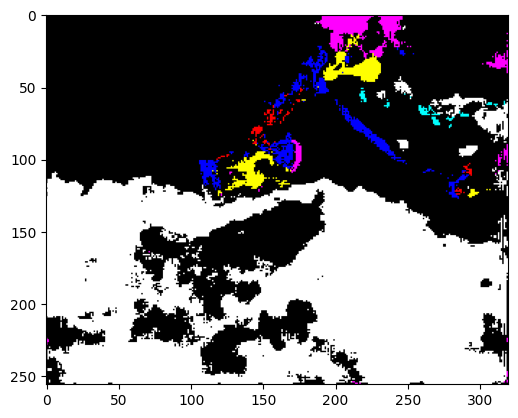

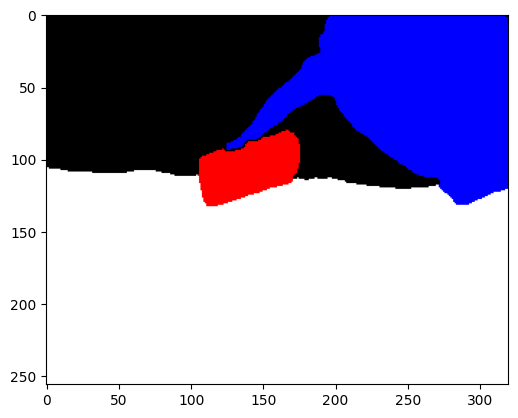

  1%|          | 1/110 [00:01<02:29,  1.37s/it]

1/1 [==============================] - 0s 27ms/step


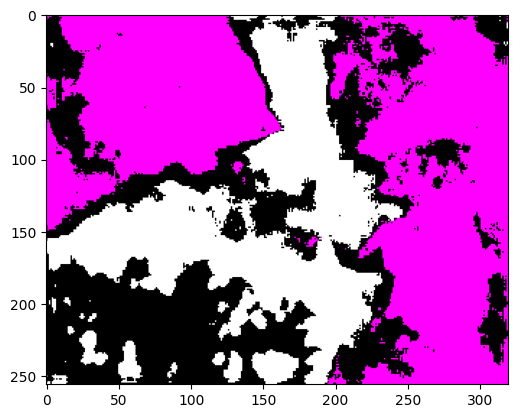

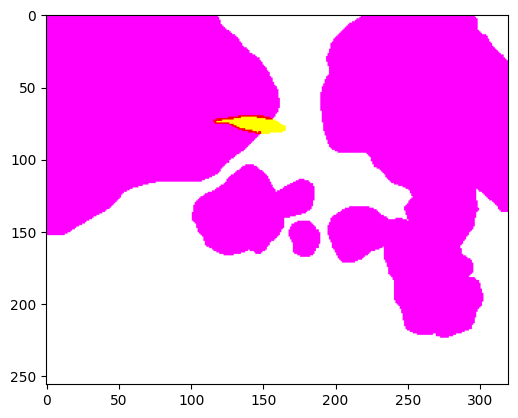

  2%|▏         | 2/110 [00:02<01:48,  1.00s/it]

1/1 [==============================] - 0s 20ms/step


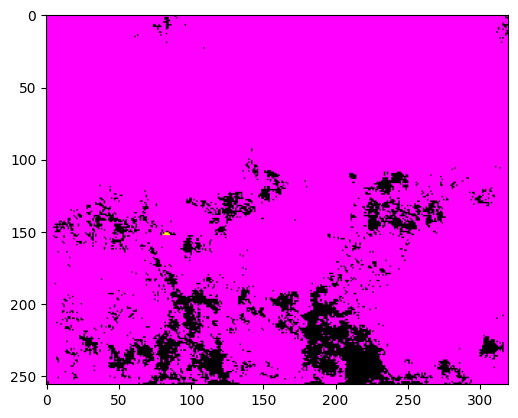

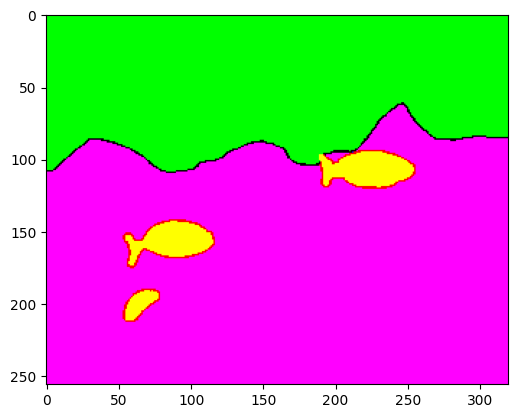

  3%|▎         | 3/110 [00:03<01:48,  1.01s/it]

1/1 [==============================] - 0s 22ms/step


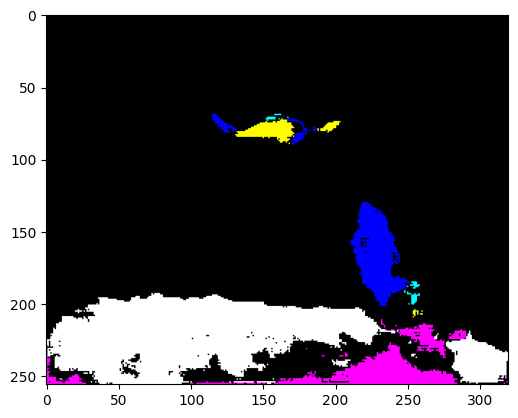

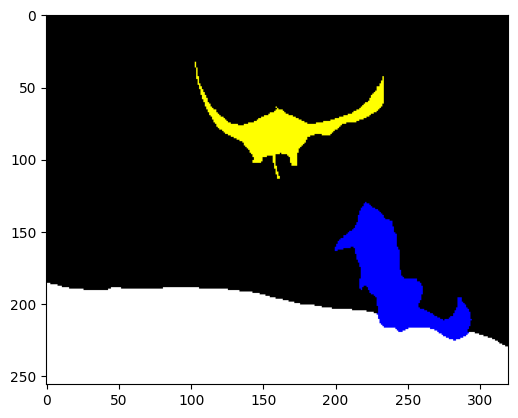

  4%|▎         | 4/110 [00:03<01:33,  1.14it/s]

1/1 [==============================] - 0s 22ms/step


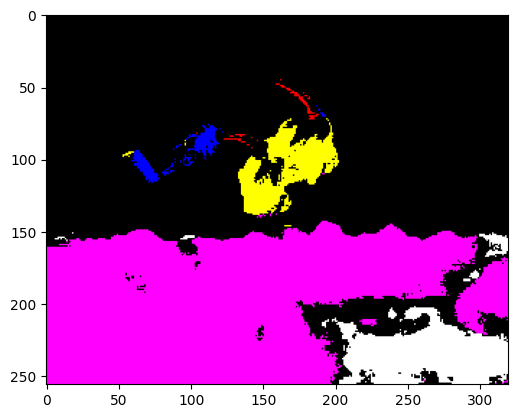

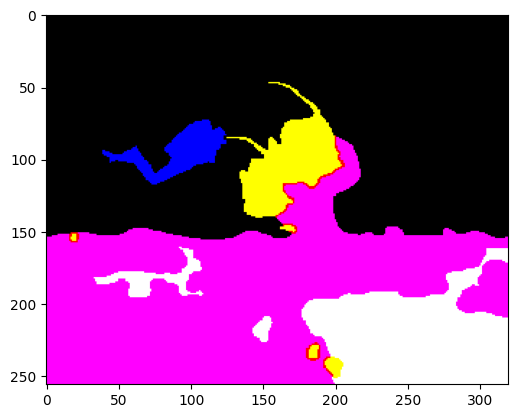

  5%|▍         | 5/110 [00:04<01:23,  1.26it/s]

1/1 [==============================] - 0s 22ms/step


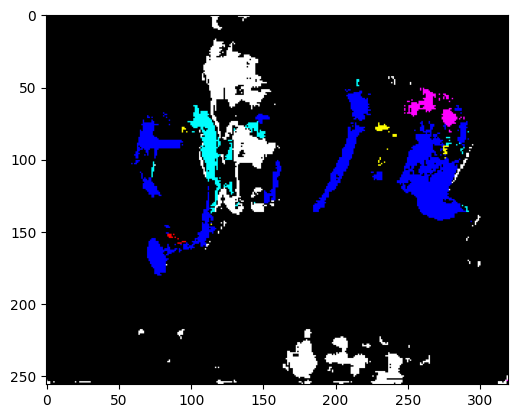

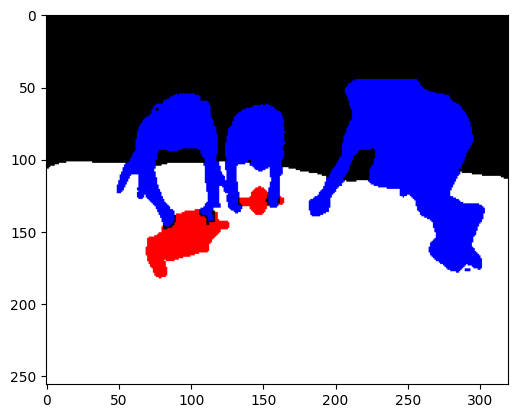

  5%|▌         | 6/110 [00:05<01:19,  1.31it/s]

1/1 [==============================] - 0s 21ms/step


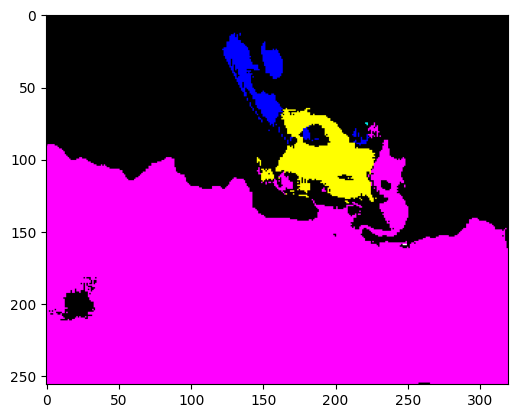

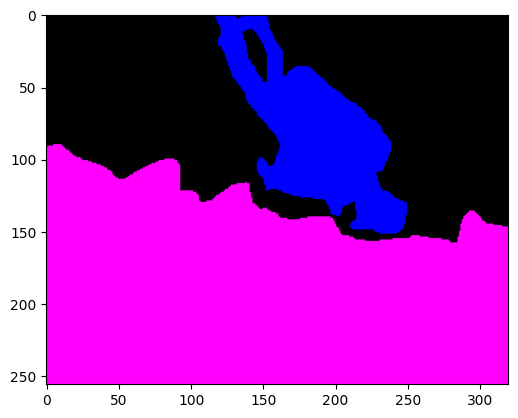

  6%|▋         | 7/110 [00:05<01:17,  1.33it/s]

1/1 [==============================] - 0s 39ms/step


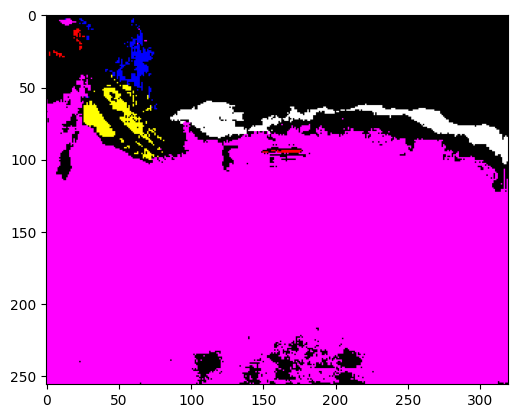

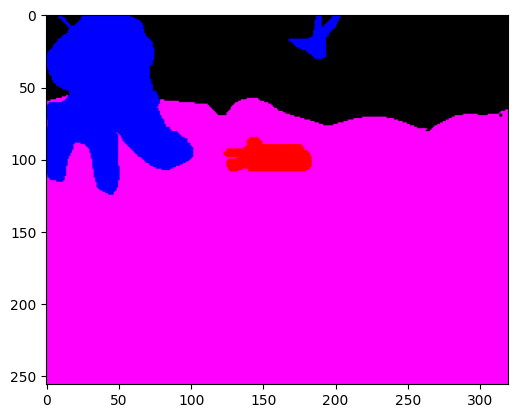

  7%|▋         | 8/110 [00:06<01:26,  1.18it/s]

1/1 [==============================] - 0s 31ms/step


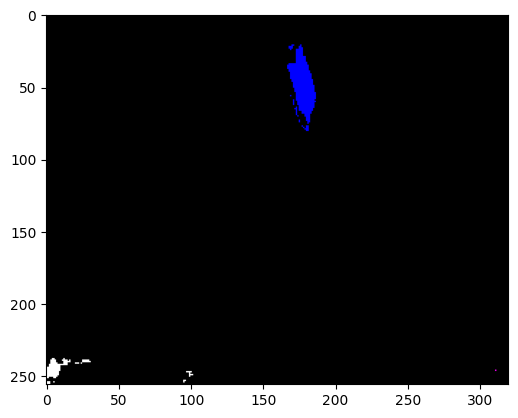

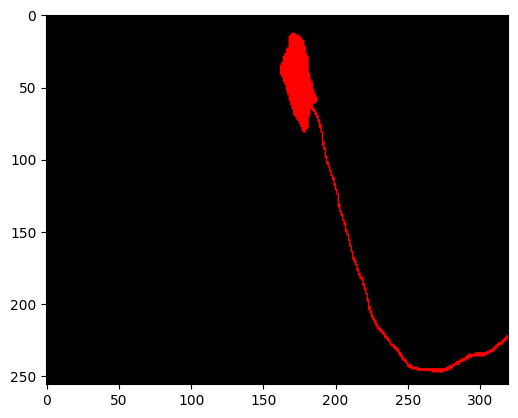

  8%|▊         | 9/110 [00:07<01:29,  1.13it/s]

1/1 [==============================] - 0s 30ms/step


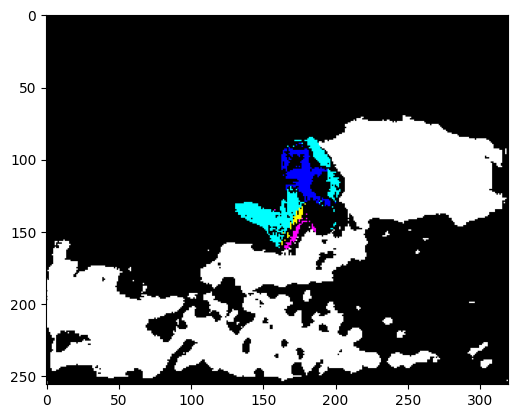

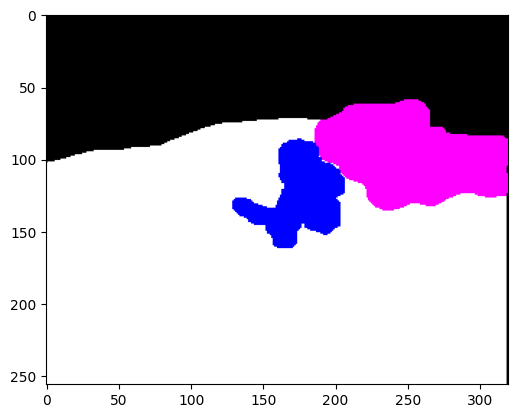

  9%|▉         | 10/110 [00:08<01:28,  1.13it/s]

1/1 [==============================] - 0s 31ms/step


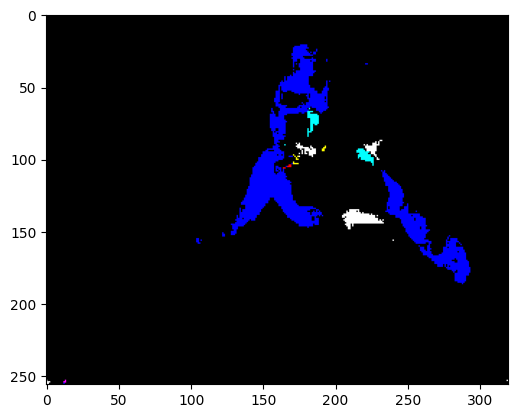

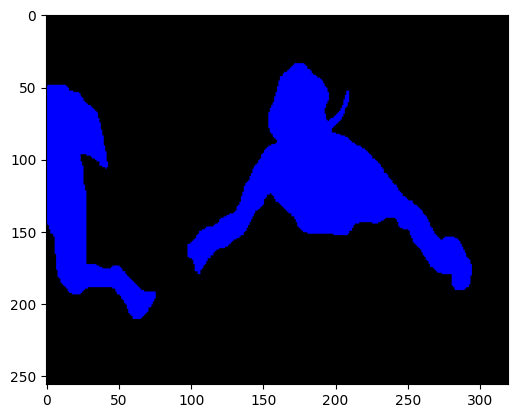

 10%|█         | 11/110 [00:09<01:28,  1.12it/s]

1/1 [==============================] - 0s 31ms/step


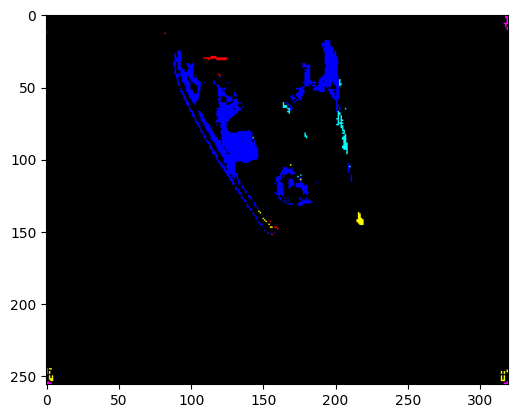

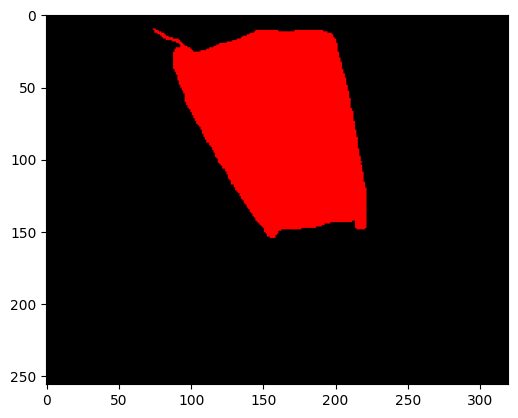

 11%|█         | 12/110 [00:10<01:30,  1.09it/s]

1/1 [==============================] - 0s 32ms/step


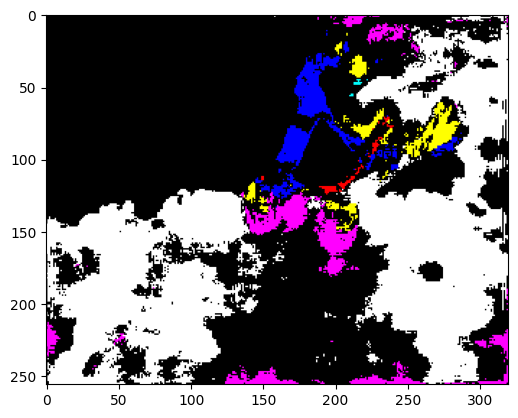

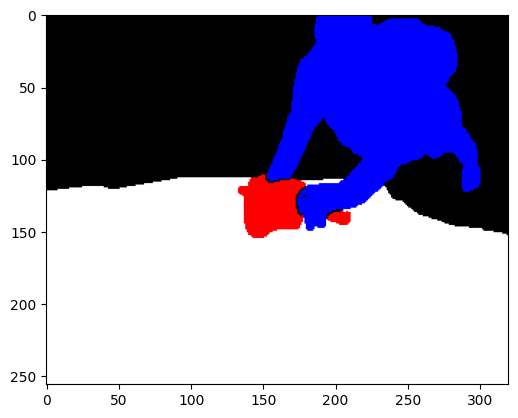

 12%|█▏        | 13/110 [00:11<01:32,  1.05it/s]

1/1 [==============================] - 0s 29ms/step


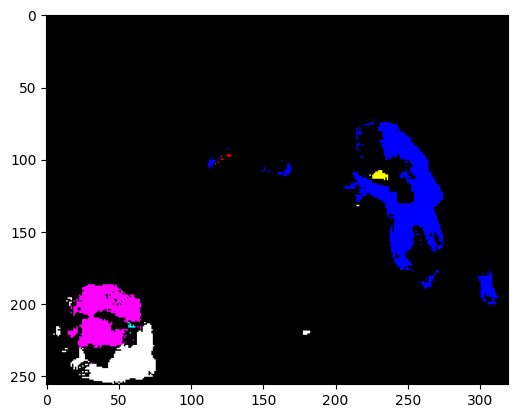

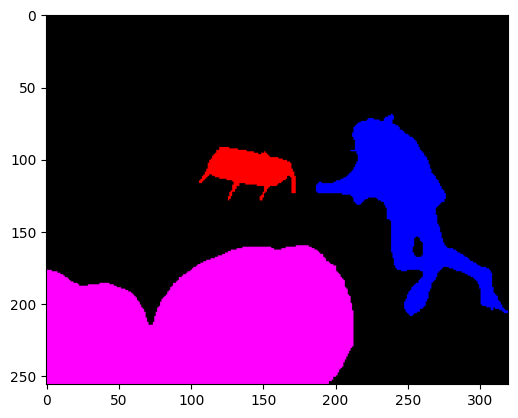

 13%|█▎        | 14/110 [00:12<01:31,  1.05it/s]

1/1 [==============================] - 0s 34ms/step


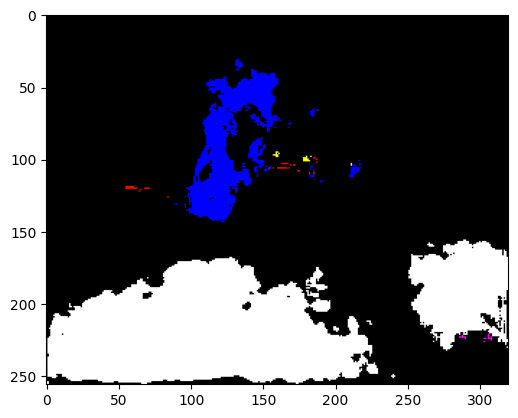

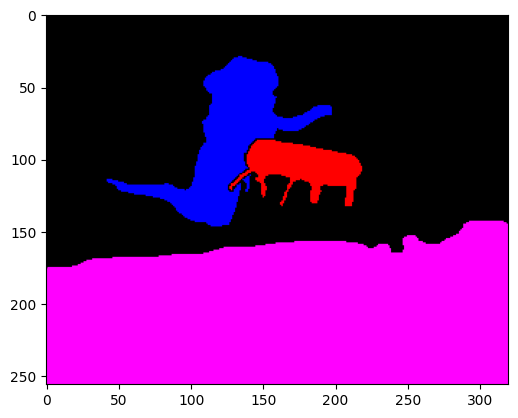

 14%|█▎        | 15/110 [00:13<01:29,  1.06it/s]

1/1 [==============================] - 0s 21ms/step


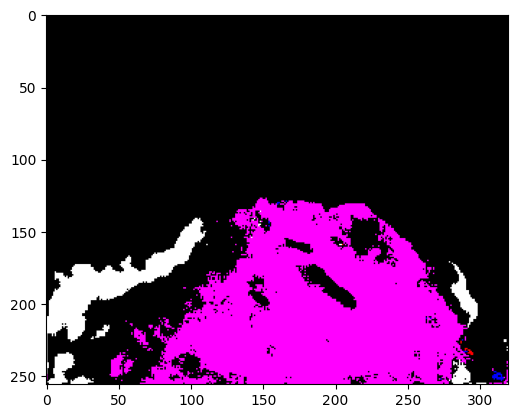

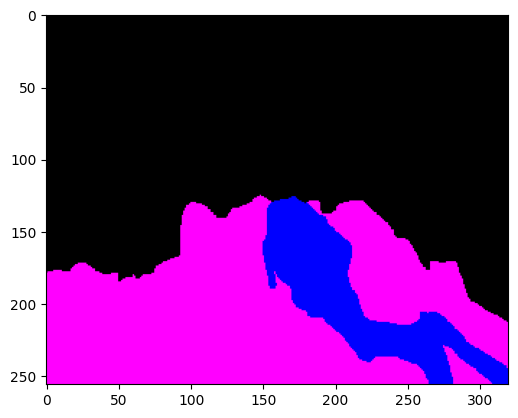

 15%|█▍        | 16/110 [00:14<01:21,  1.16it/s]

1/1 [==============================] - 0s 20ms/step


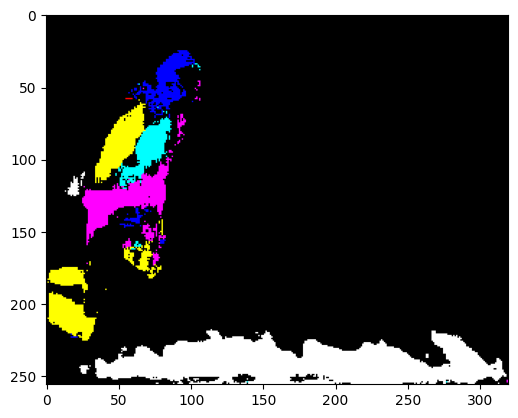

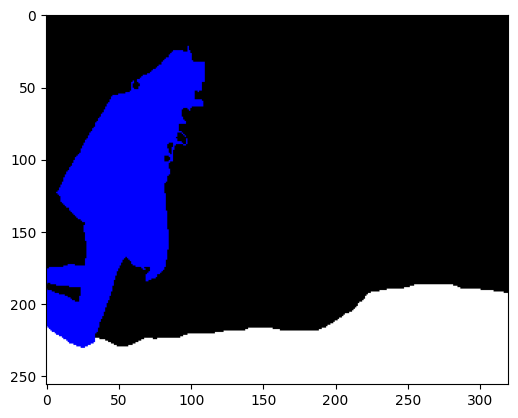

 15%|█▌        | 17/110 [00:14<01:15,  1.23it/s]

1/1 [==============================] - 0s 20ms/step


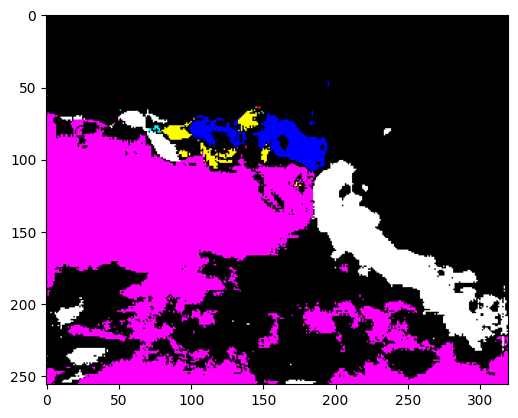

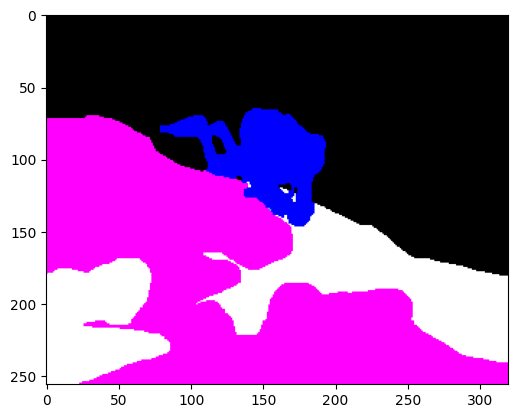

 16%|█▋        | 18/110 [00:15<01:11,  1.29it/s]

1/1 [==============================] - 0s 22ms/step


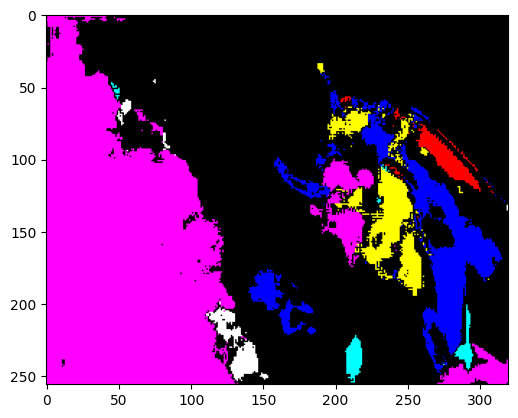

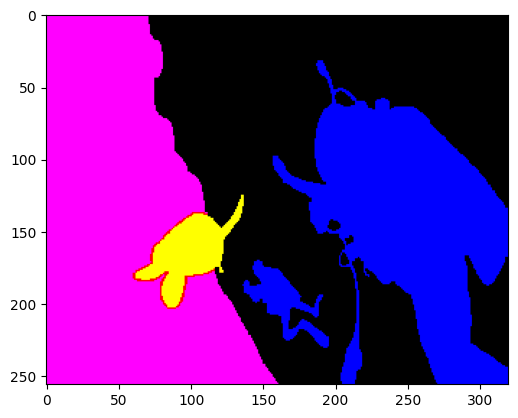

 17%|█▋        | 19/110 [00:16<01:08,  1.34it/s]

1/1 [==============================] - 0s 24ms/step


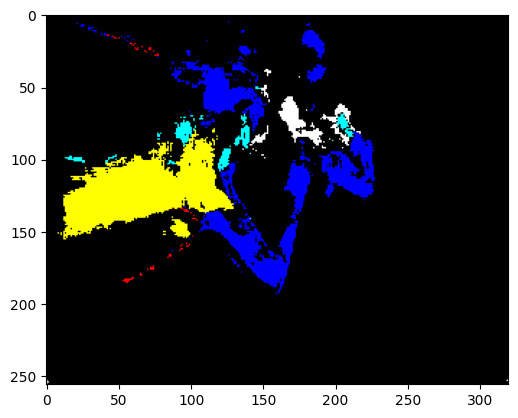

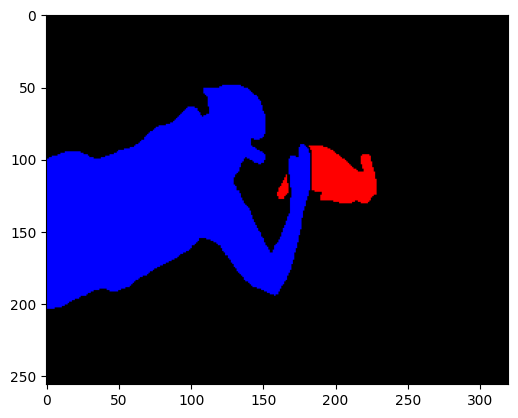

 18%|█▊        | 20/110 [00:17<01:05,  1.37it/s]

1/1 [==============================] - 0s 22ms/step


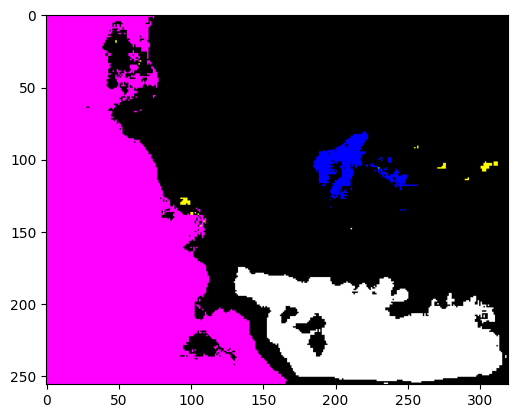

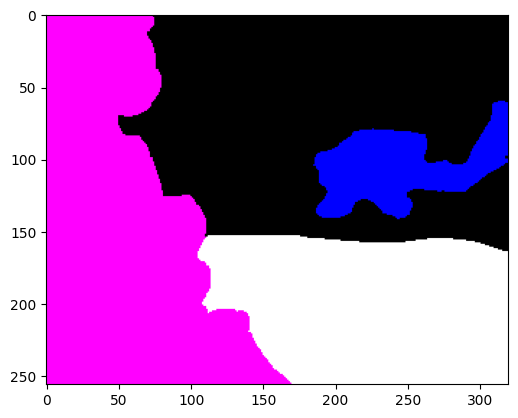

 19%|█▉        | 21/110 [00:17<01:04,  1.38it/s]

1/1 [==============================] - 0s 22ms/step


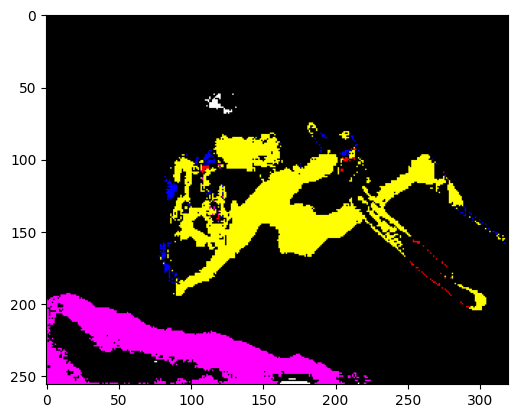

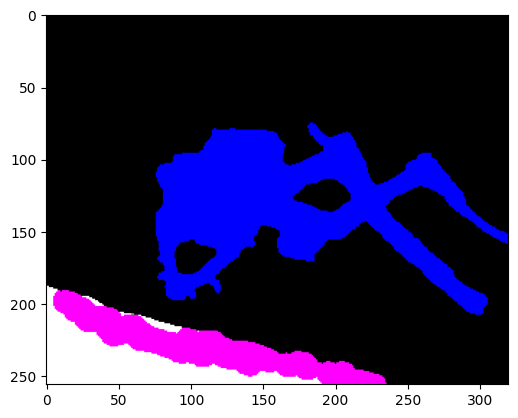

 20%|██        | 22/110 [00:18<01:02,  1.40it/s]

1/1 [==============================] - 0s 21ms/step


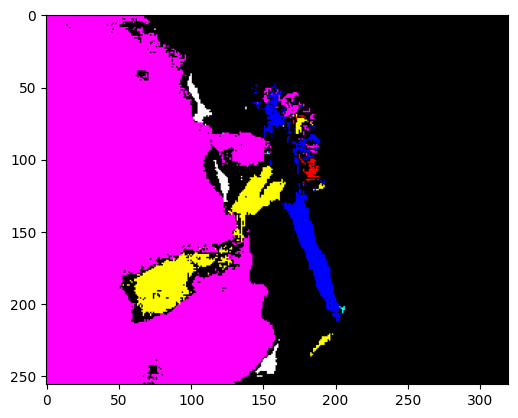

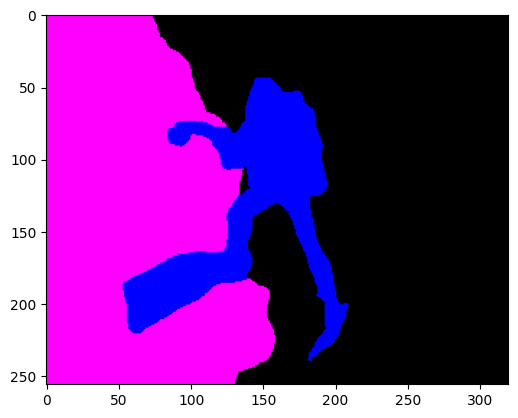

 21%|██        | 23/110 [00:19<01:03,  1.36it/s]

1/1 [==============================] - 0s 49ms/step


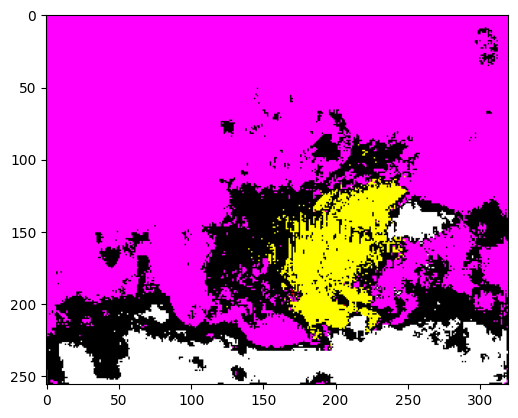

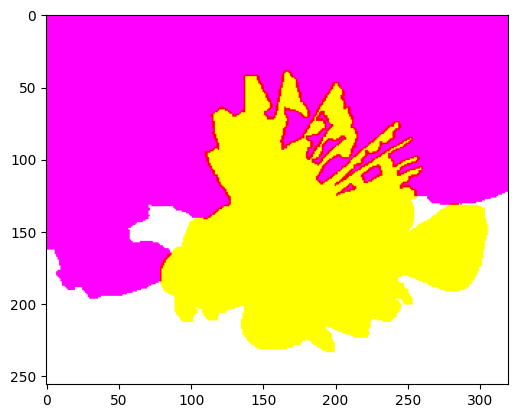

 22%|██▏       | 24/110 [00:20<01:16,  1.13it/s]

1/1 [==============================] - 0s 33ms/step


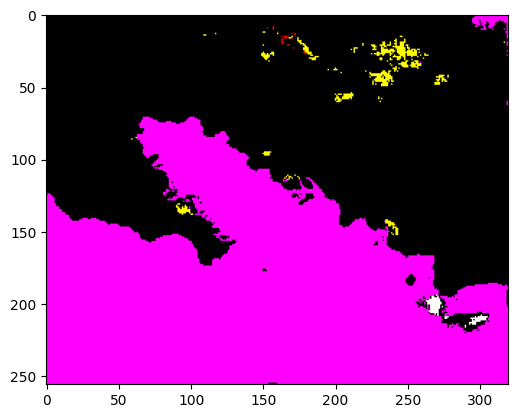

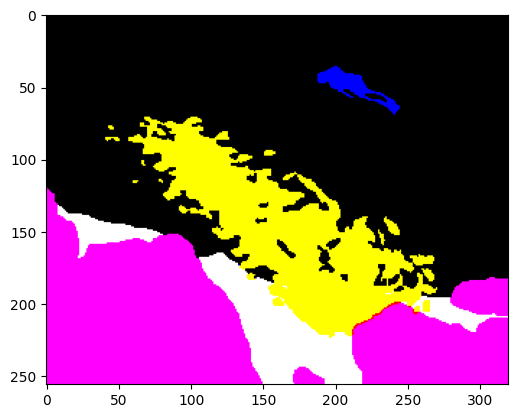

 23%|██▎       | 25/110 [00:21<01:25,  1.00s/it]

1/1 [==============================] - 0s 59ms/step


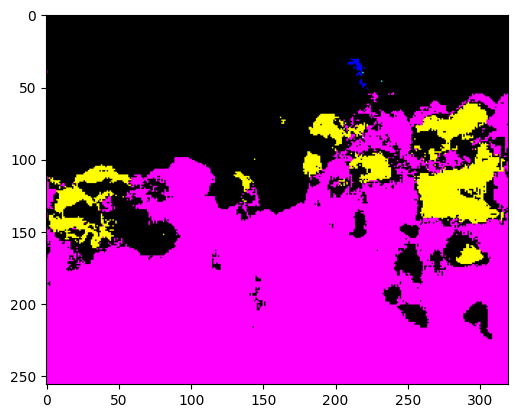

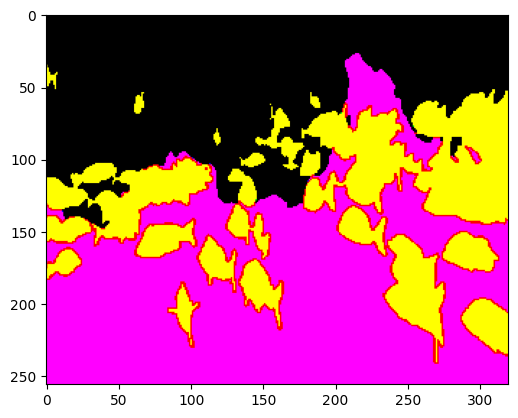

 24%|██▎       | 26/110 [00:22<01:19,  1.06it/s]

1/1 [==============================] - 0s 25ms/step


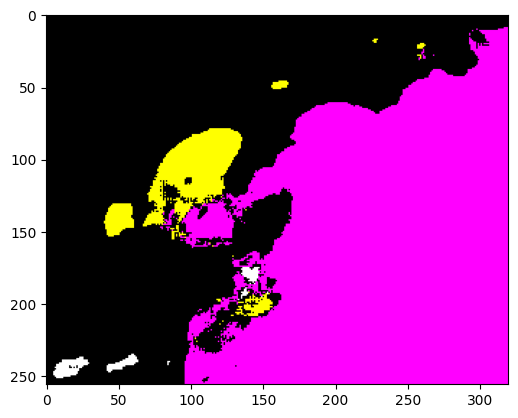

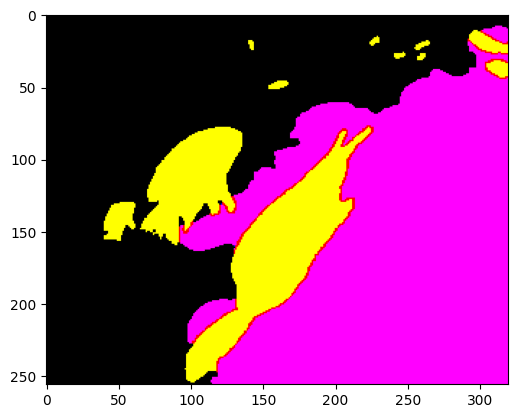

 25%|██▍       | 27/110 [00:23<01:12,  1.15it/s]

1/1 [==============================] - 0s 20ms/step


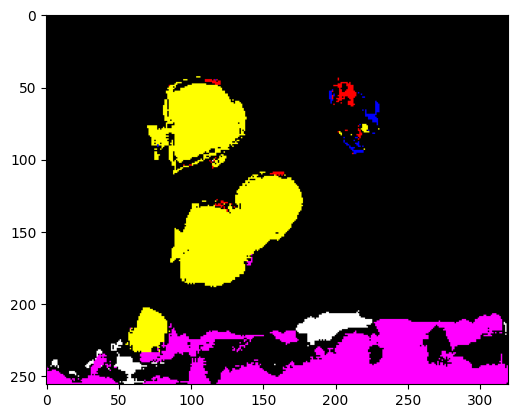

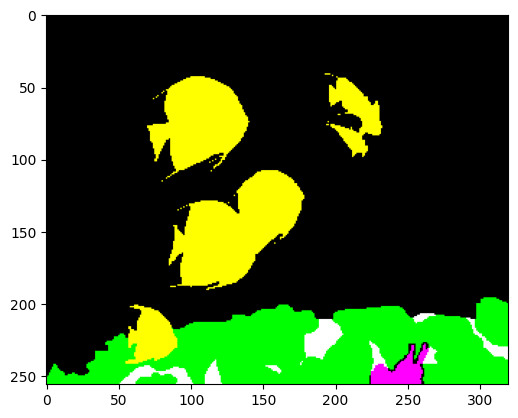

 25%|██▌       | 28/110 [00:24<01:12,  1.14it/s]

1/1 [==============================] - 0s 37ms/step


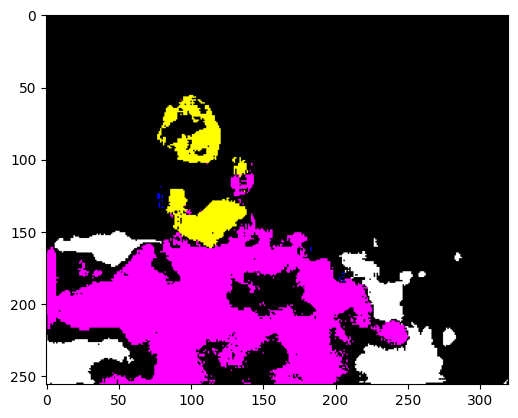

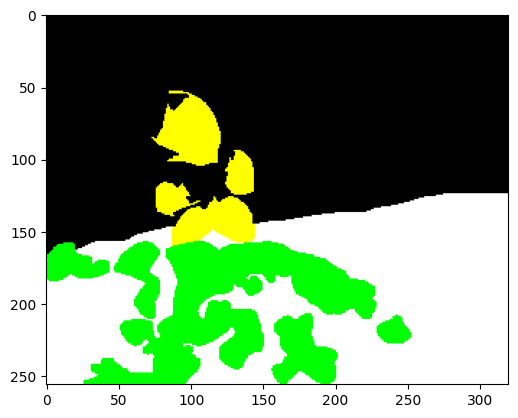

 26%|██▋       | 29/110 [00:25<01:14,  1.09it/s]

1/1 [==============================] - 0s 44ms/step


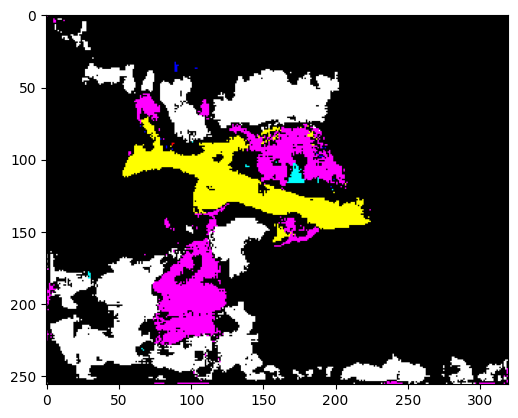

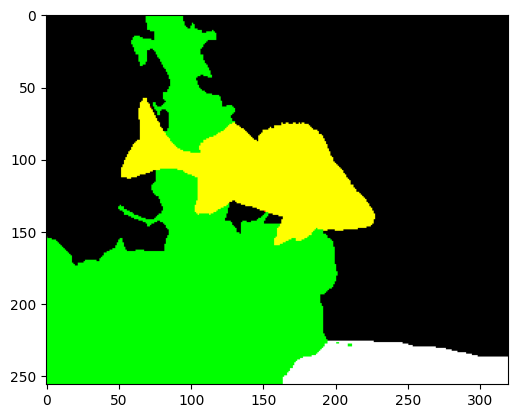

 27%|██▋       | 30/110 [00:26<01:14,  1.07it/s]

1/1 [==============================] - 0s 29ms/step


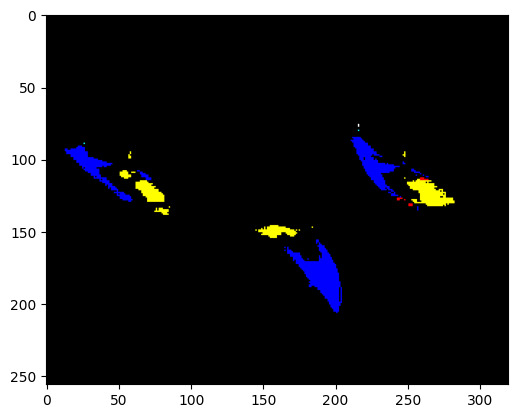

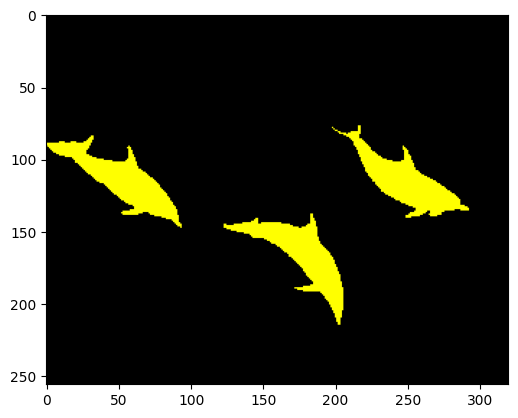

 28%|██▊       | 31/110 [00:27<01:14,  1.07it/s]

1/1 [==============================] - 0s 31ms/step


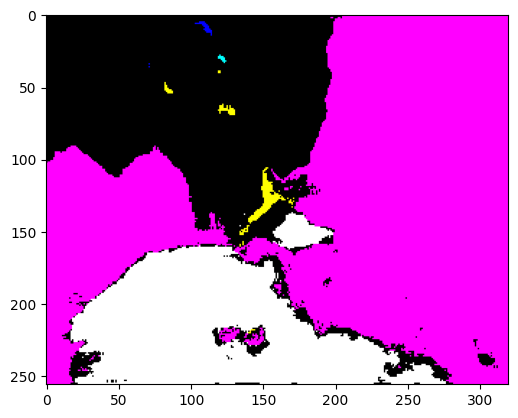

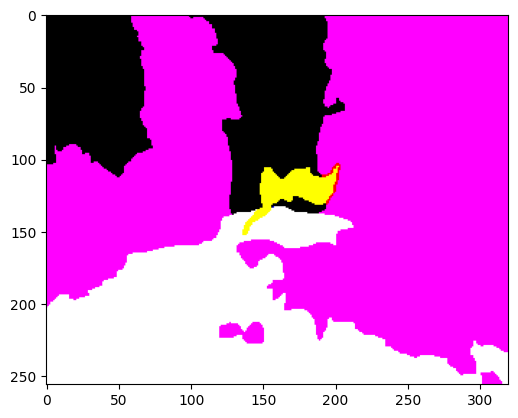

 29%|██▉       | 32/110 [00:28<01:13,  1.06it/s]

1/1 [==============================] - 0s 49ms/step


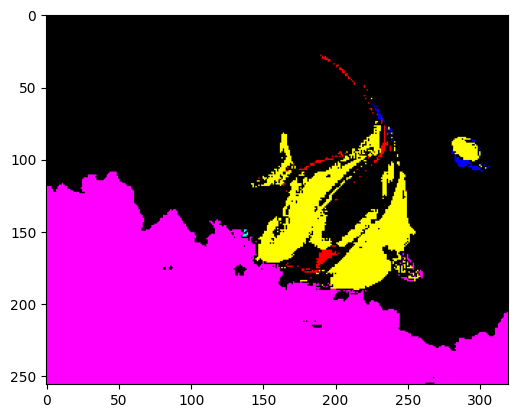

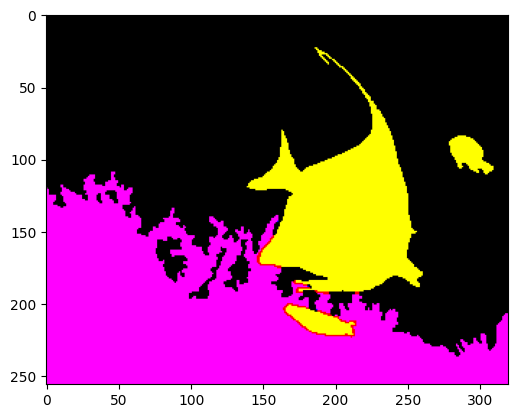

 30%|███       | 33/110 [00:29<01:15,  1.02it/s]

1/1 [==============================] - 0s 34ms/step


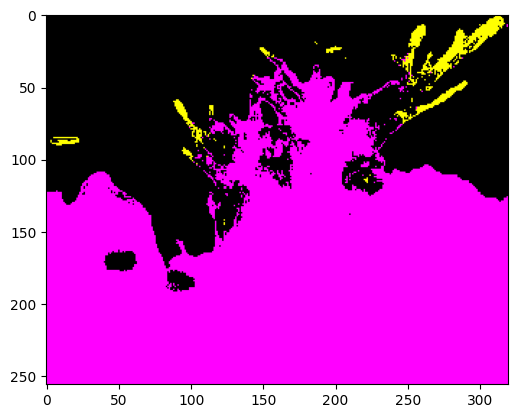

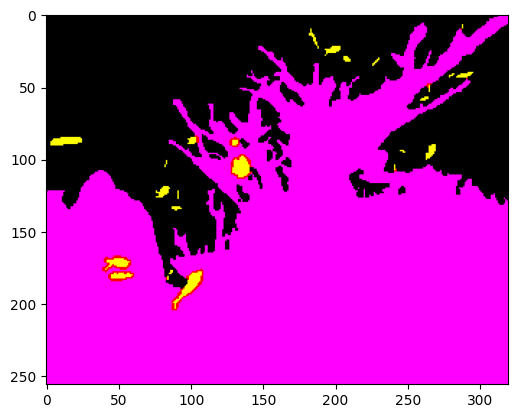

 31%|███       | 34/110 [00:30<01:15,  1.00it/s]

1/1 [==============================] - 0s 31ms/step


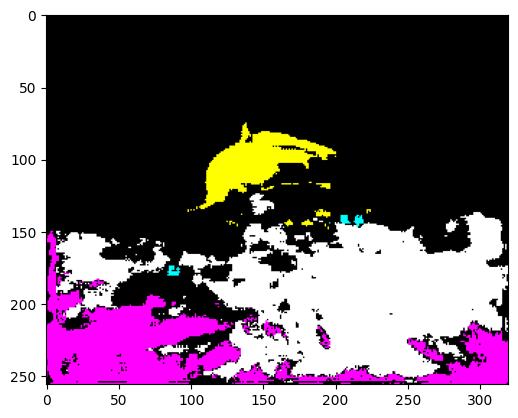

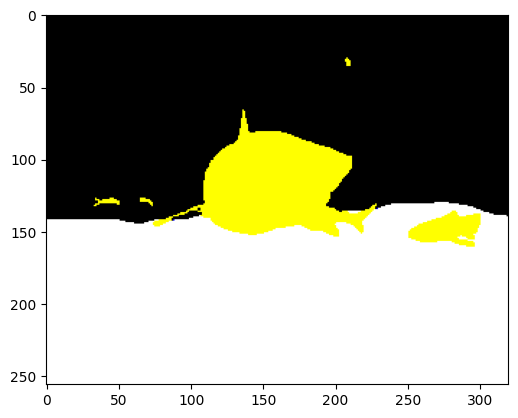

 32%|███▏      | 35/110 [00:31<01:14,  1.01it/s]

1/1 [==============================] - 0s 28ms/step


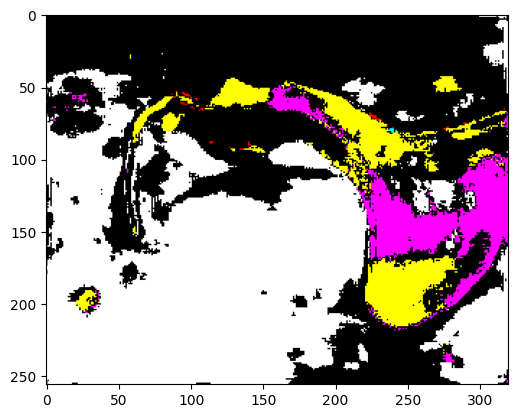

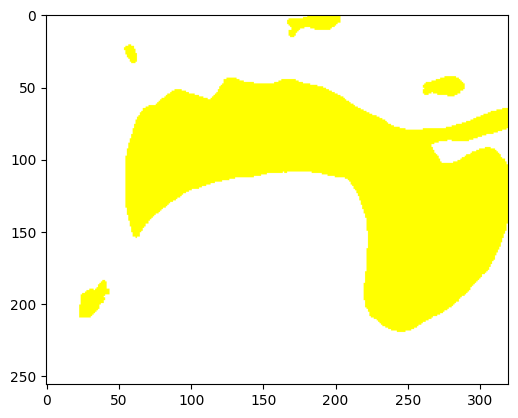

 33%|███▎      | 36/110 [00:32<01:12,  1.02it/s]

1/1 [==============================] - 0s 29ms/step


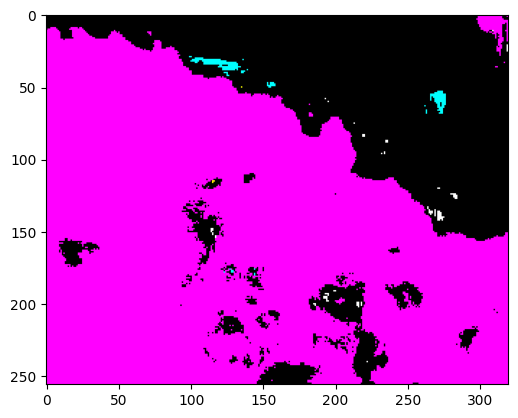

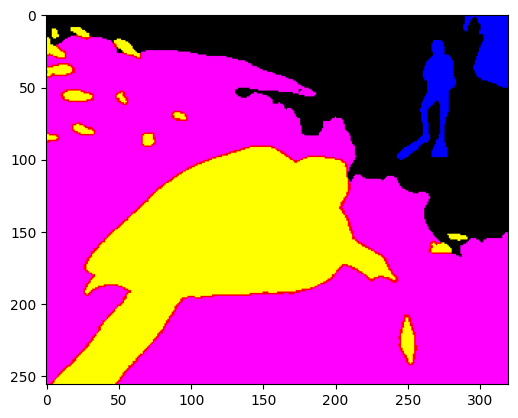

 34%|███▎      | 37/110 [00:32<01:05,  1.11it/s]

1/1 [==============================] - 0s 25ms/step


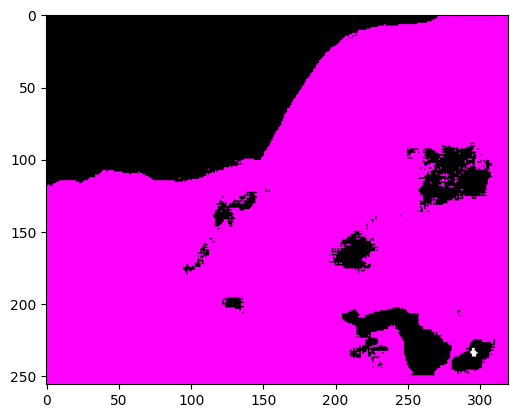

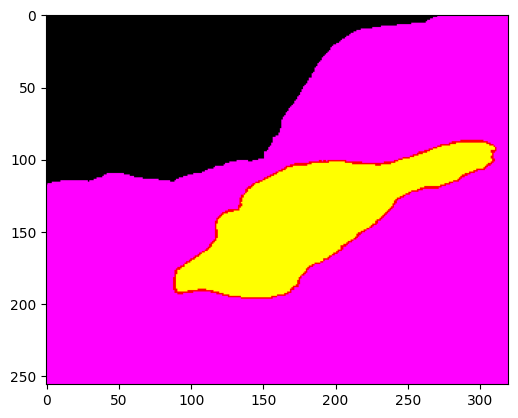

 35%|███▍      | 38/110 [00:33<01:00,  1.19it/s]

1/1 [==============================] - 0s 25ms/step


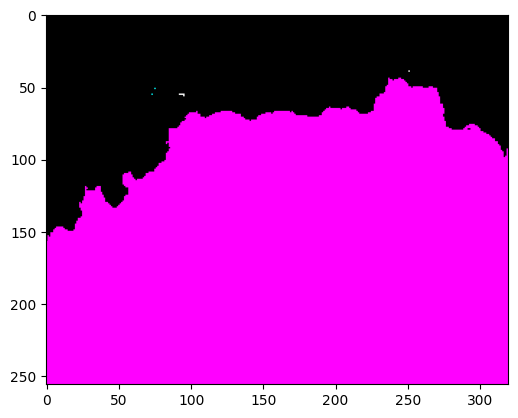

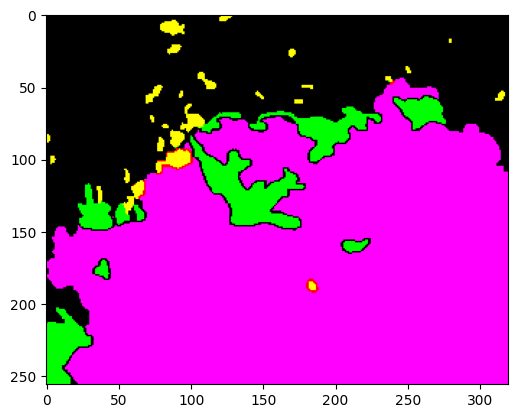

 35%|███▌      | 39/110 [00:34<00:57,  1.24it/s]

1/1 [==============================] - 0s 28ms/step


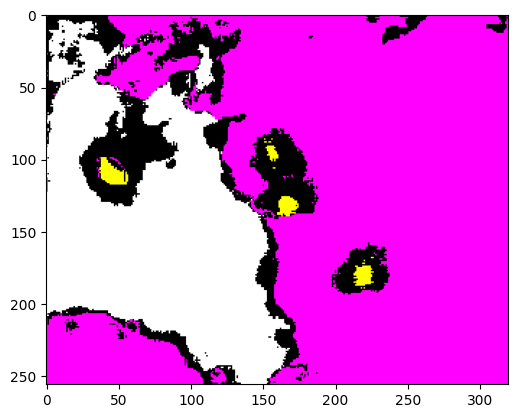

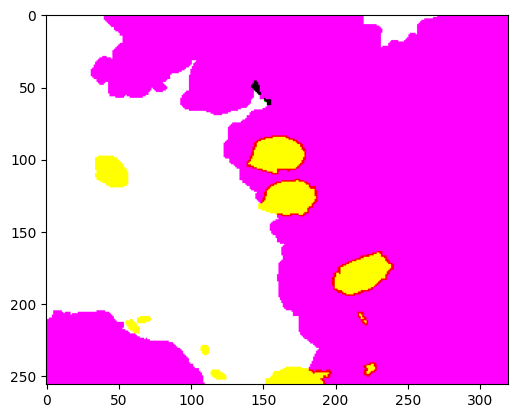

 36%|███▋      | 40/110 [00:34<00:54,  1.28it/s]

1/1 [==============================] - 0s 27ms/step


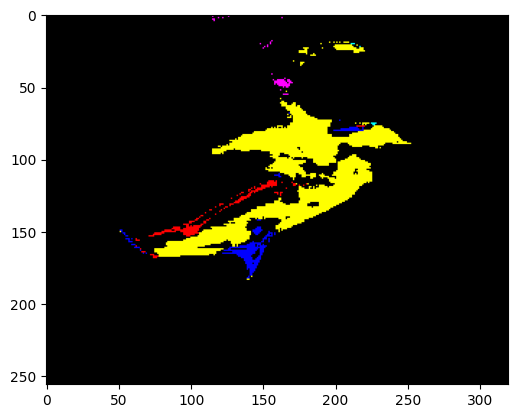

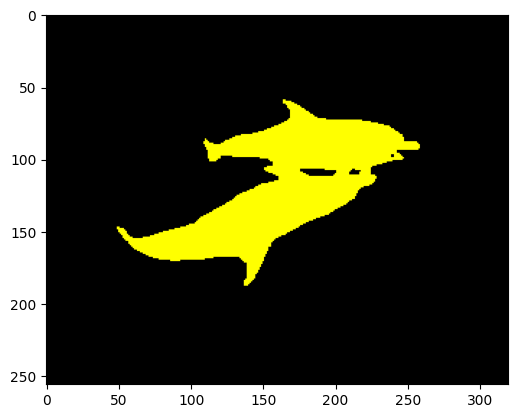

 37%|███▋      | 41/110 [00:35<00:52,  1.31it/s]

1/1 [==============================] - 0s 28ms/step


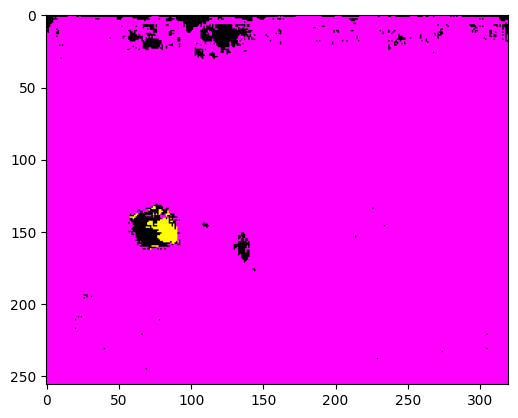

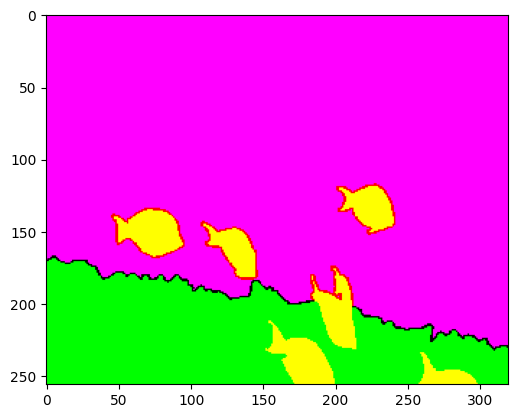

 38%|███▊      | 42/110 [00:36<00:50,  1.33it/s]

1/1 [==============================] - 0s 29ms/step


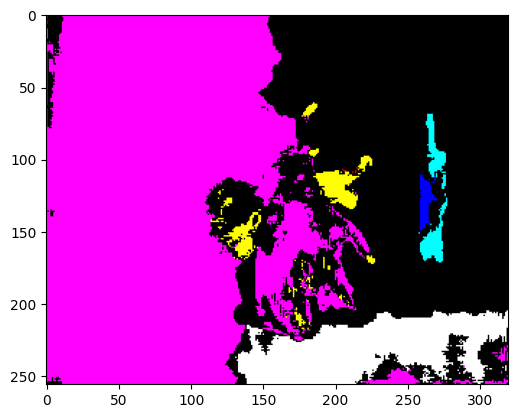

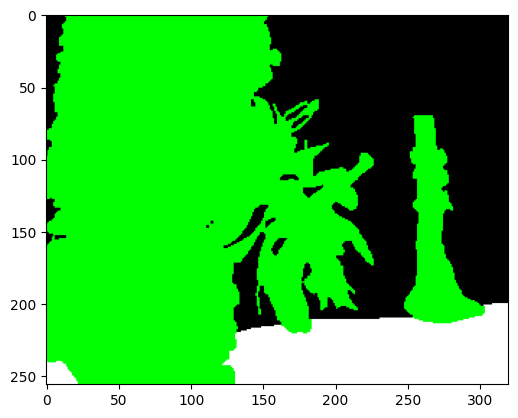

 39%|███▉      | 43/110 [00:37<00:49,  1.36it/s]

1/1 [==============================] - 0s 29ms/step


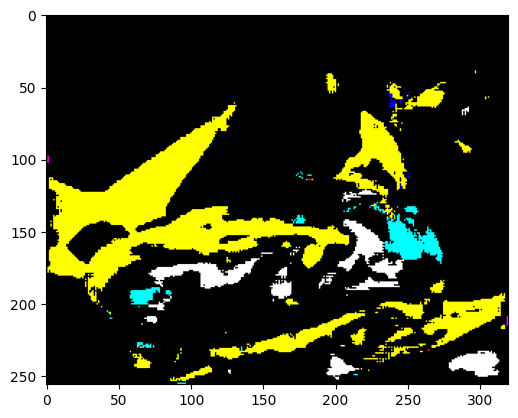

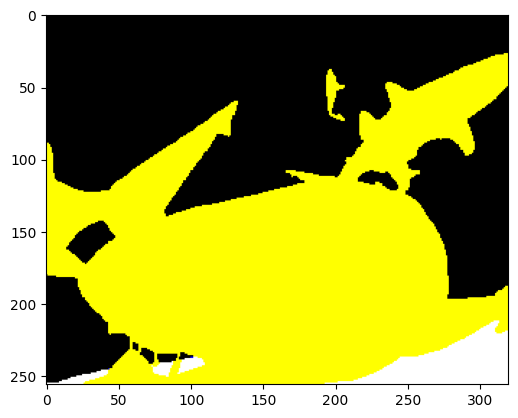

 40%|████      | 44/110 [00:38<00:55,  1.19it/s]

1/1 [==============================] - 0s 28ms/step


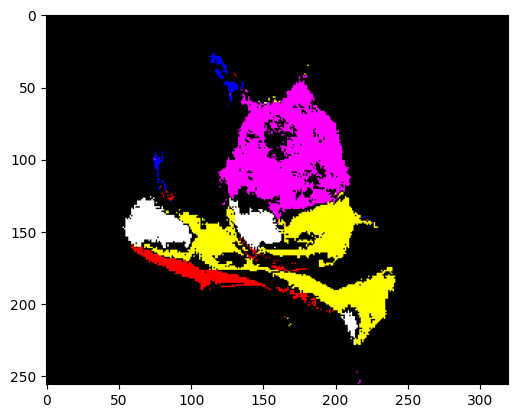

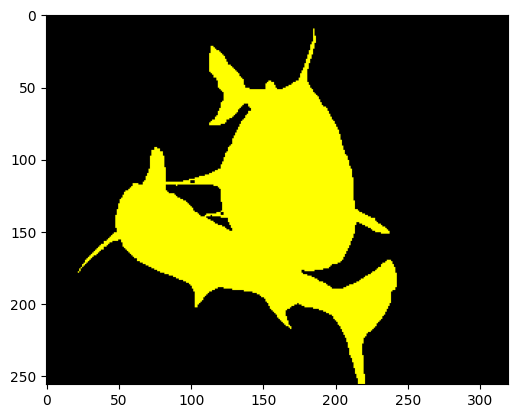

 41%|████      | 45/110 [00:38<00:52,  1.23it/s]

1/1 [==============================] - 0s 30ms/step


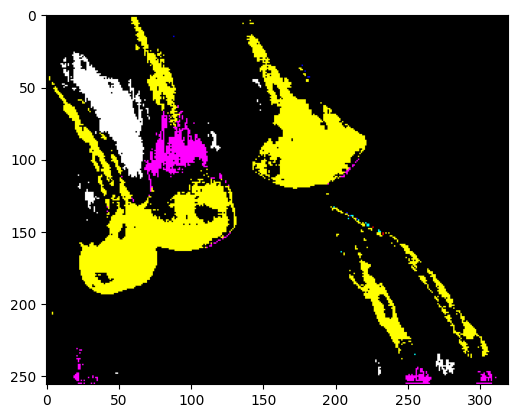

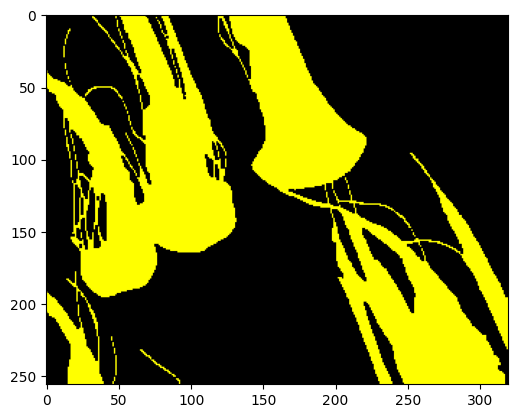

 42%|████▏     | 46/110 [00:39<00:51,  1.25it/s]

1/1 [==============================] - 0s 35ms/step


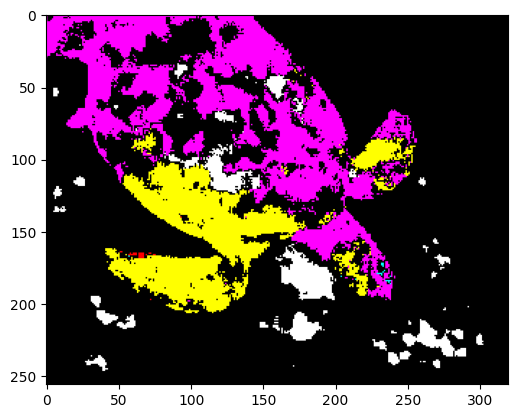

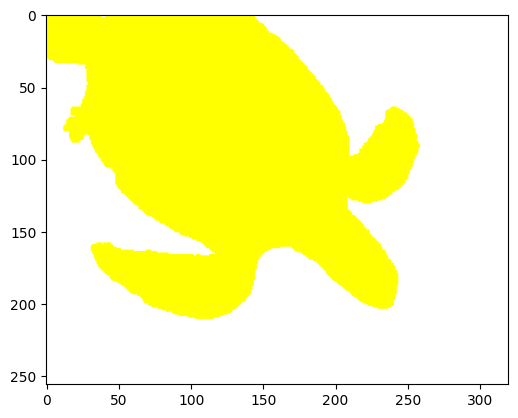

 43%|████▎     | 47/110 [00:40<00:49,  1.28it/s]

1/1 [==============================] - 0s 32ms/step


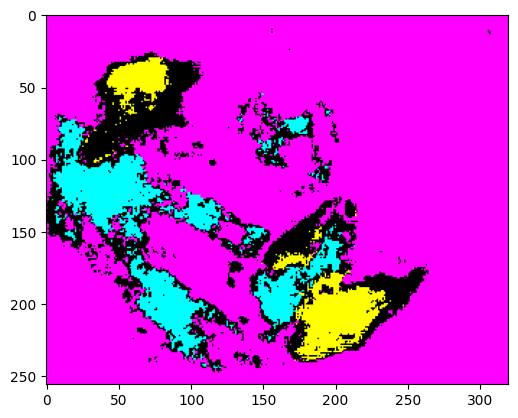

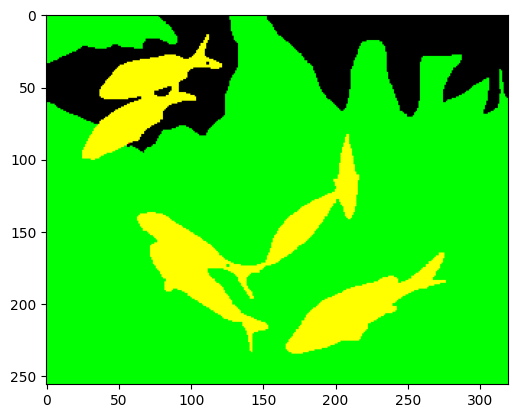

 44%|████▎     | 48/110 [00:41<00:48,  1.29it/s]

1/1 [==============================] - 0s 34ms/step


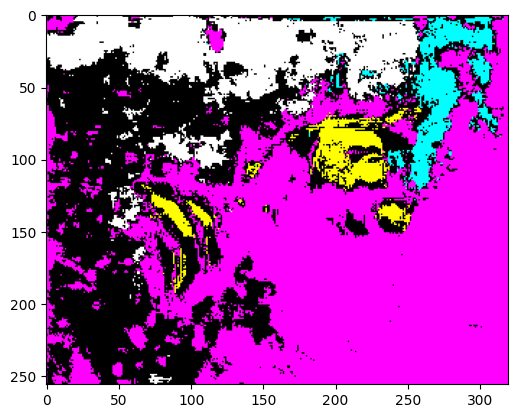

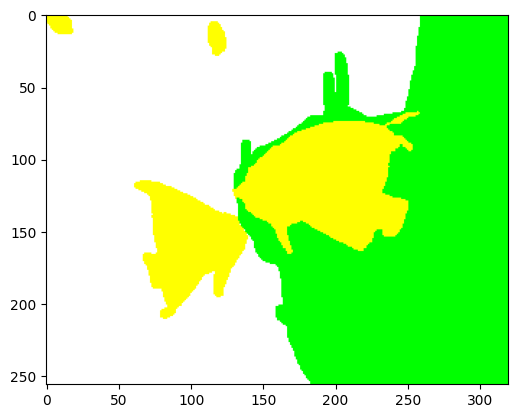

 45%|████▍     | 49/110 [00:41<00:47,  1.30it/s]

1/1 [==============================] - 0s 48ms/step


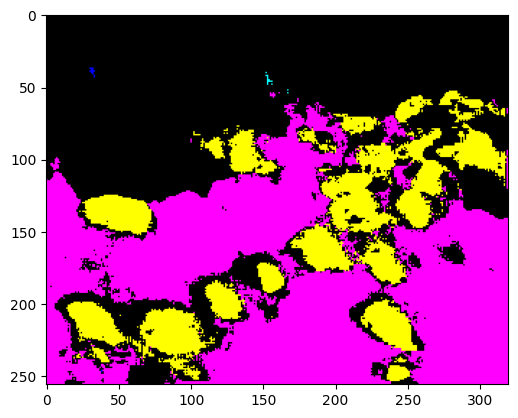

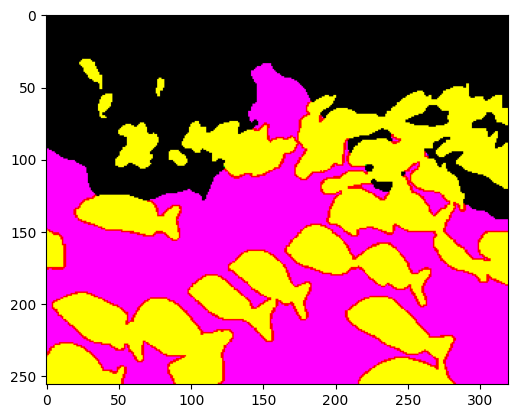

 45%|████▌     | 50/110 [00:42<00:51,  1.17it/s]

1/1 [==============================] - 0s 36ms/step


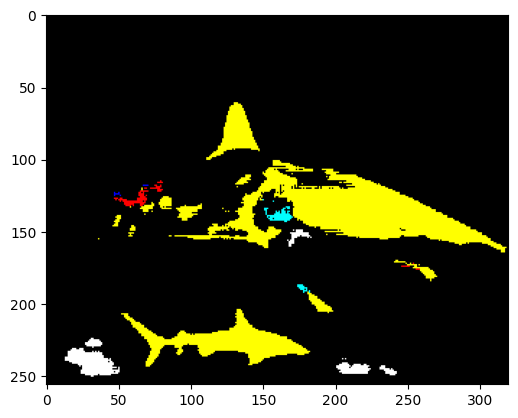

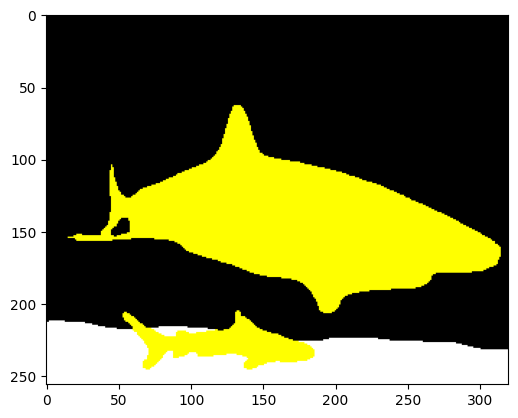

 46%|████▋     | 51/110 [00:43<00:52,  1.13it/s]

1/1 [==============================] - 0s 38ms/step


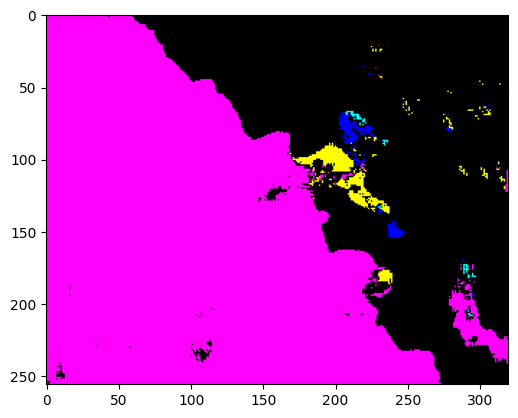

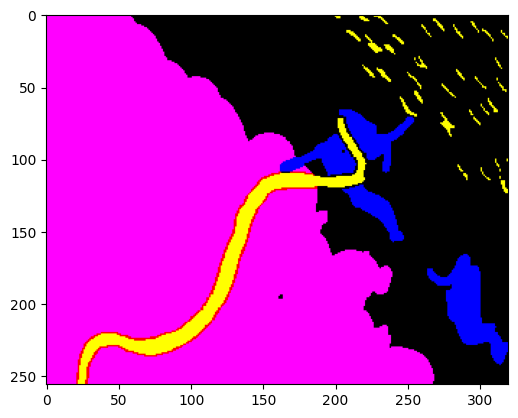

 47%|████▋     | 52/110 [00:44<00:52,  1.11it/s]

1/1 [==============================] - 0s 33ms/step


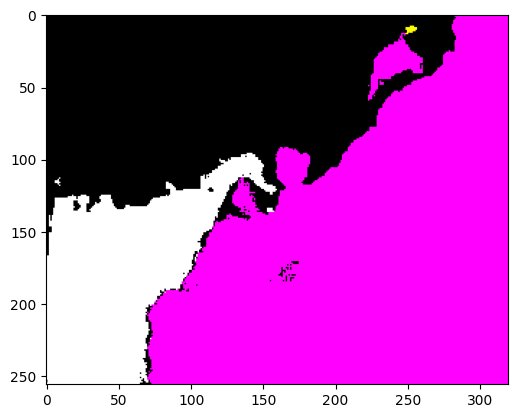

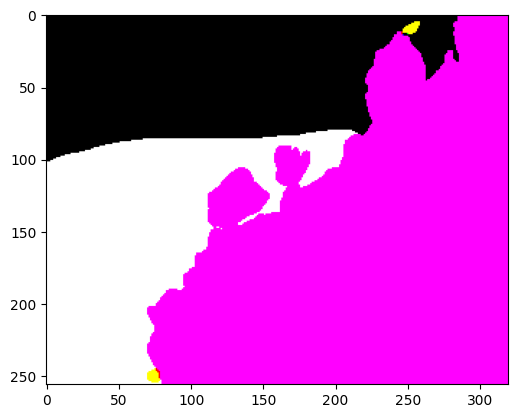

 48%|████▊     | 53/110 [00:45<00:52,  1.09it/s]

1/1 [==============================] - 0s 31ms/step


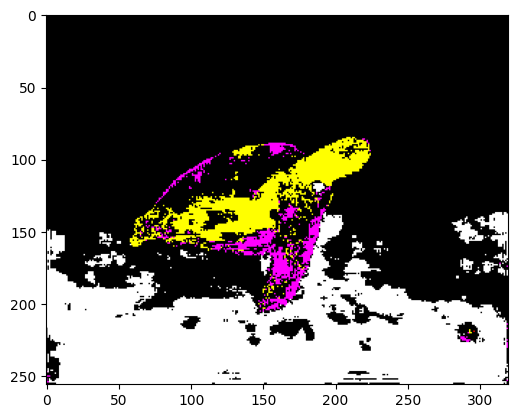

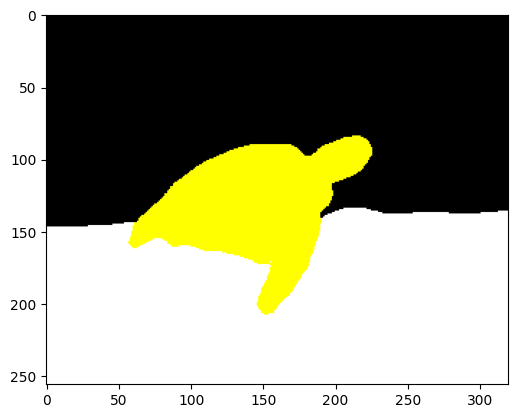

 49%|████▉     | 54/110 [00:46<00:52,  1.06it/s]

1/1 [==============================] - 0s 35ms/step


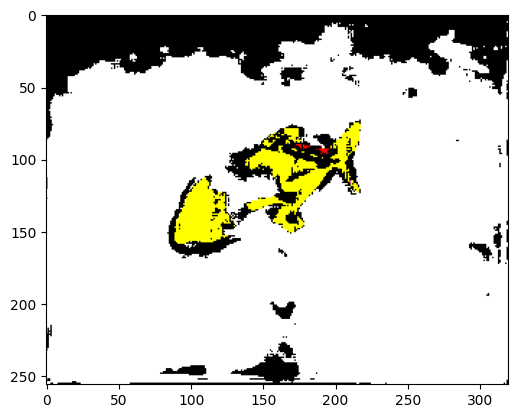

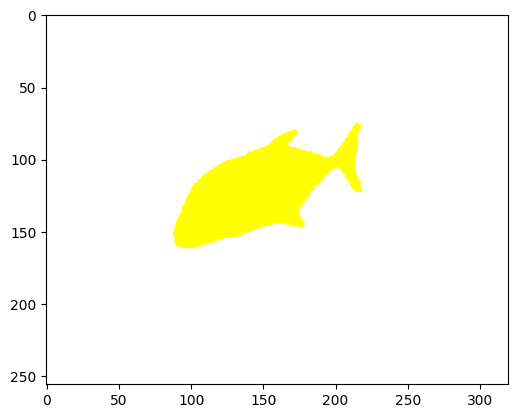

 50%|█████     | 55/110 [00:47<00:52,  1.05it/s]

1/1 [==============================] - 0s 63ms/step


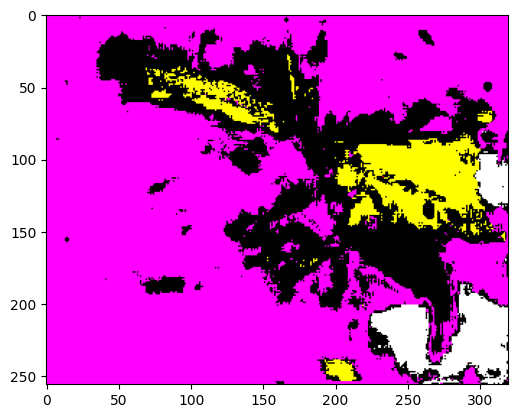

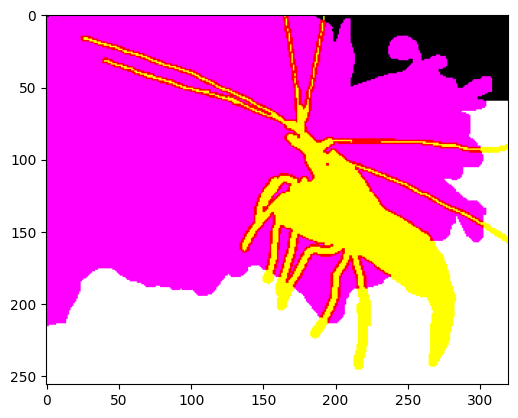

 51%|█████     | 56/110 [00:48<00:54,  1.01s/it]

1/1 [==============================] - 0s 35ms/step


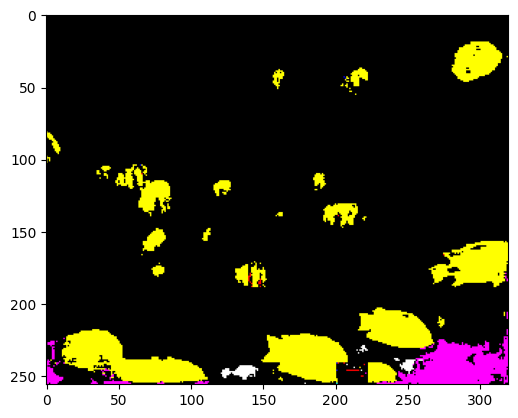

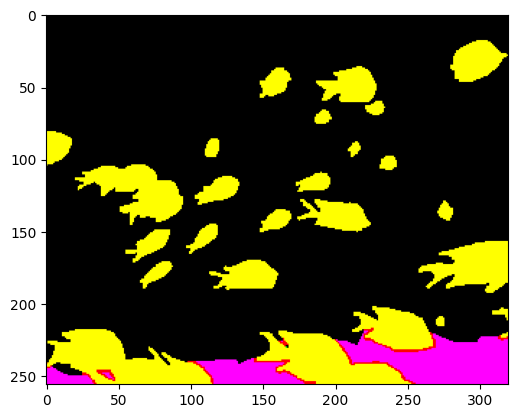

 52%|█████▏    | 57/110 [00:49<00:53,  1.01s/it]

1/1 [==============================] - 0s 51ms/step


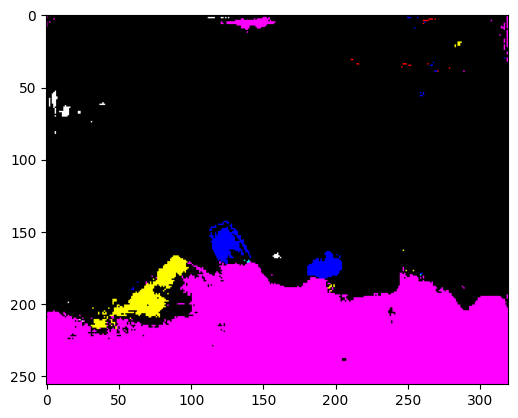

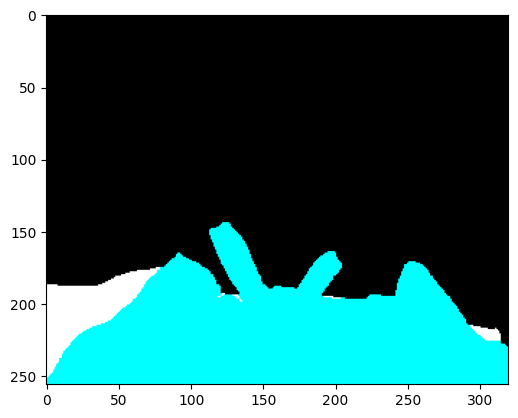

 53%|█████▎    | 58/110 [00:50<00:52,  1.01s/it]

1/1 [==============================] - 0s 50ms/step


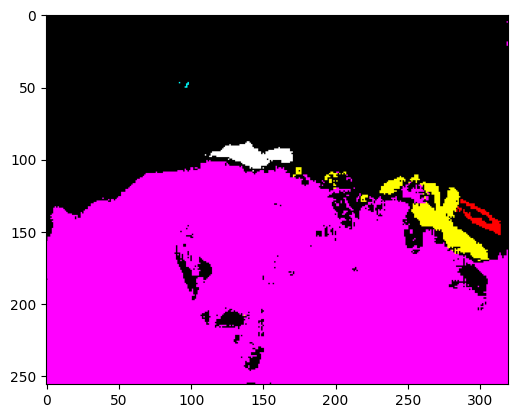

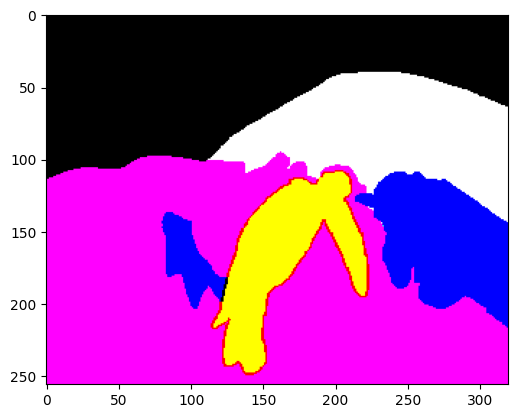

 54%|█████▎    | 59/110 [00:51<00:50,  1.00it/s]

1/1 [==============================] - 0s 31ms/step


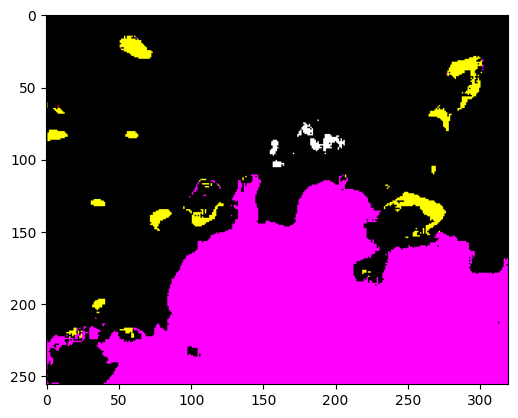

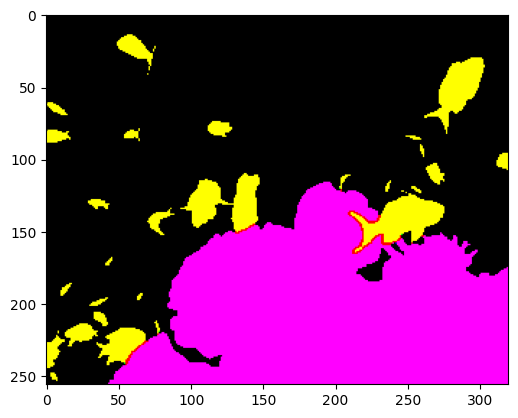

 55%|█████▍    | 60/110 [00:52<00:46,  1.09it/s]

1/1 [==============================] - 0s 35ms/step


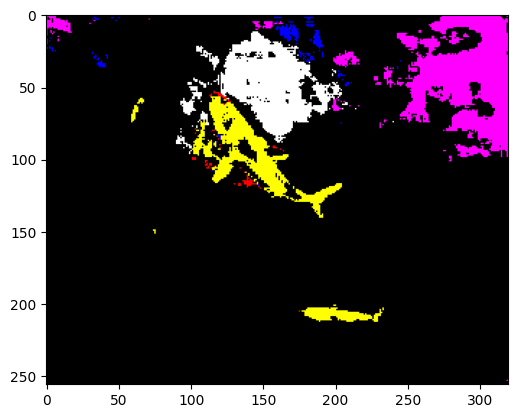

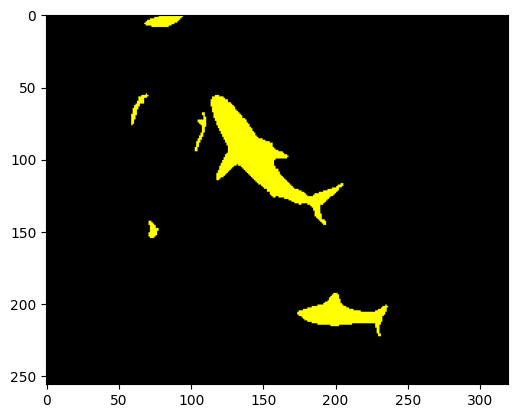

 55%|█████▌    | 61/110 [00:53<00:42,  1.15it/s]

1/1 [==============================] - 0s 28ms/step


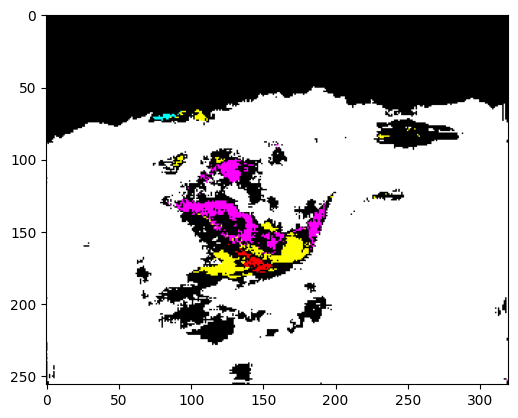

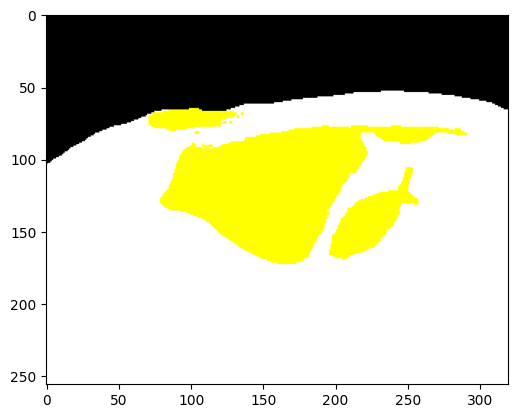

 56%|█████▋    | 62/110 [00:54<00:40,  1.19it/s]

1/1 [==============================] - 0s 38ms/step


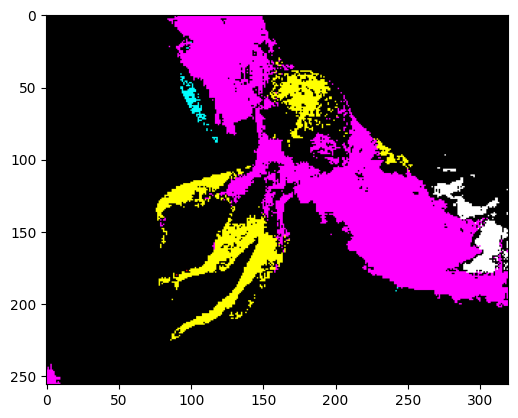

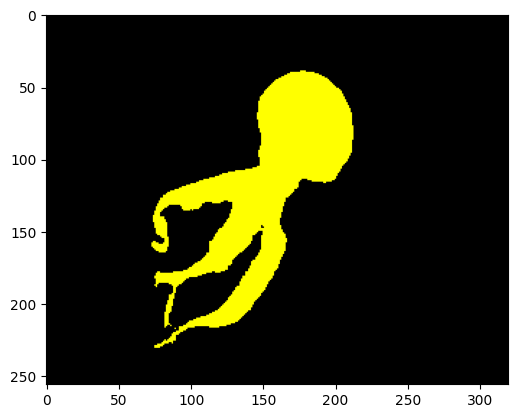

 57%|█████▋    | 63/110 [00:54<00:38,  1.23it/s]

1/1 [==============================] - 0s 32ms/step


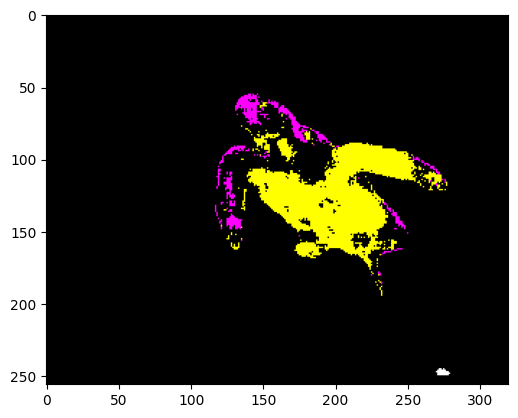

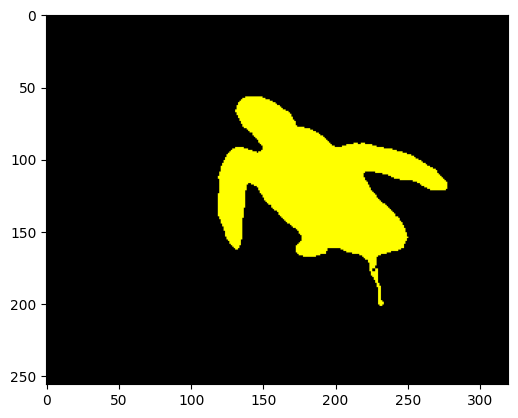

 58%|█████▊    | 64/110 [00:55<00:36,  1.25it/s]

1/1 [==============================] - 0s 32ms/step


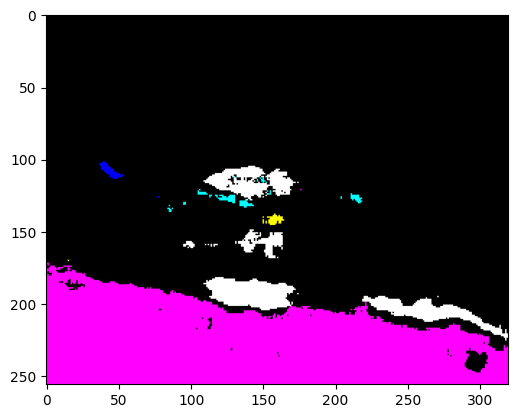

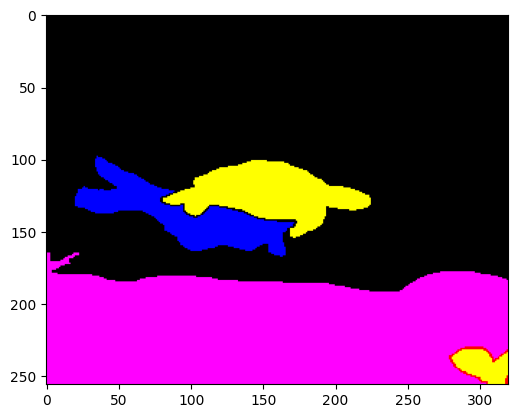

 59%|█████▉    | 65/110 [00:56<00:35,  1.26it/s]

1/1 [==============================] - 0s 29ms/step


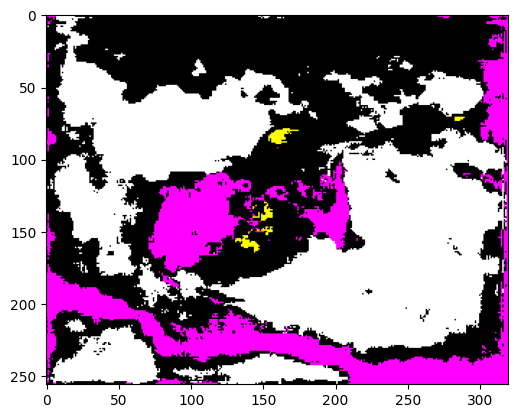

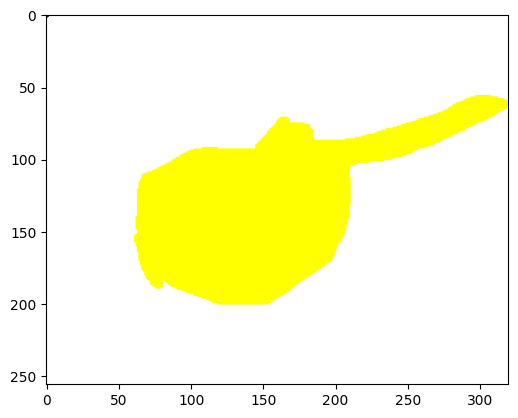

 60%|██████    | 66/110 [00:57<00:34,  1.26it/s]

1/1 [==============================] - 0s 30ms/step


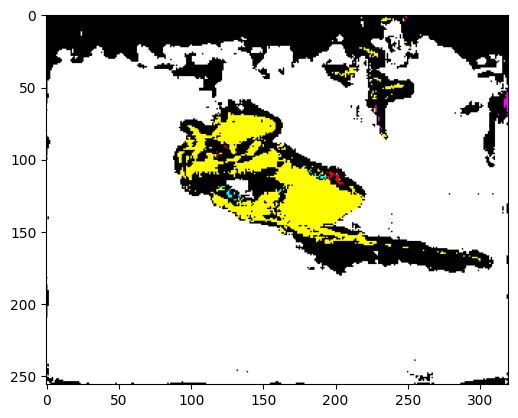

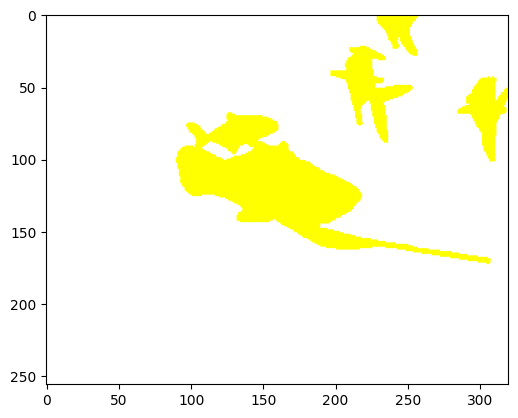

 61%|██████    | 67/110 [00:58<00:33,  1.27it/s]

1/1 [==============================] - 0s 31ms/step


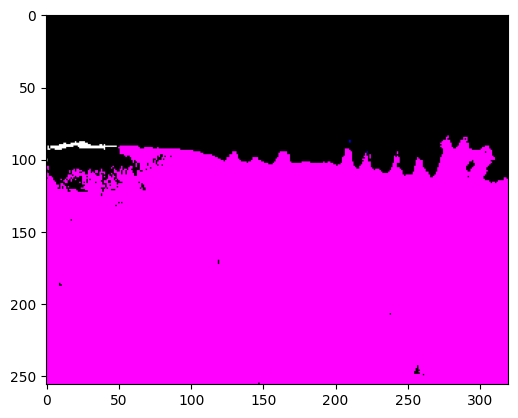

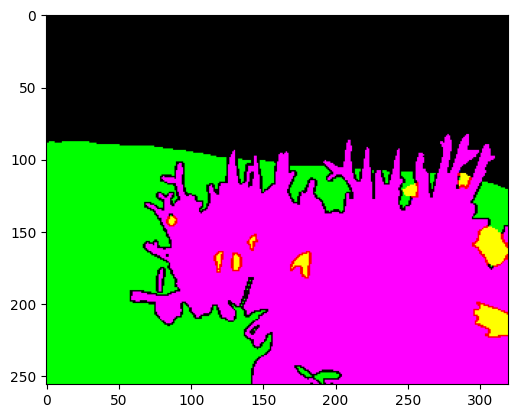

 62%|██████▏   | 68/110 [00:58<00:33,  1.27it/s]

1/1 [==============================] - 0s 33ms/step


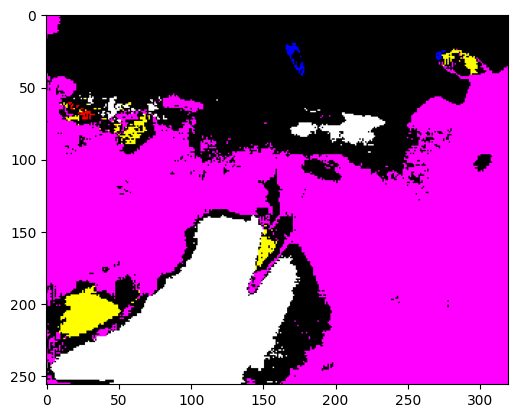

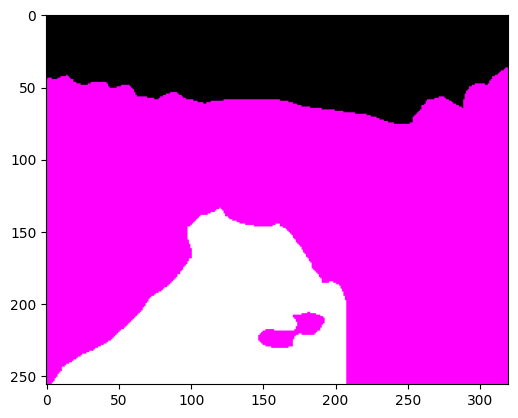

 63%|██████▎   | 69/110 [00:59<00:32,  1.27it/s]

1/1 [==============================] - 0s 36ms/step


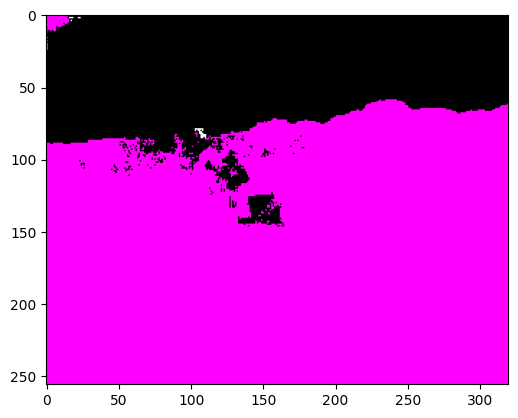

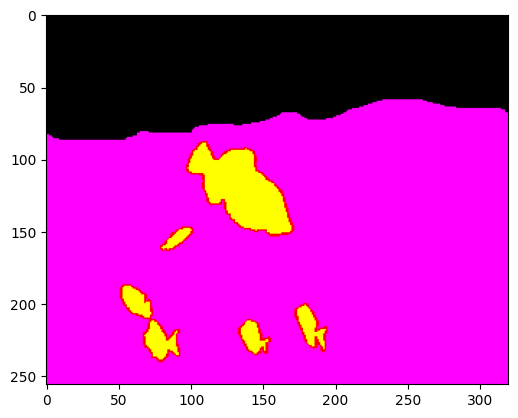

 64%|██████▎   | 70/110 [01:00<00:31,  1.27it/s]

1/1 [==============================] - 0s 31ms/step


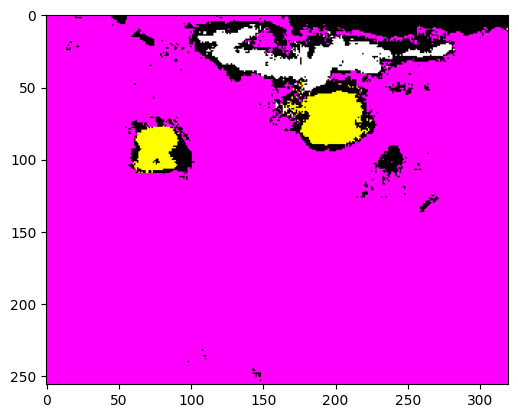

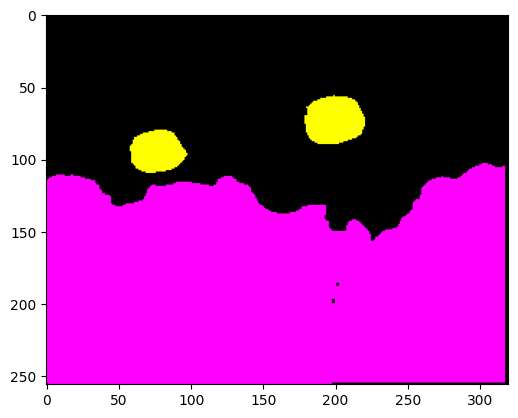

 65%|██████▍   | 71/110 [01:01<00:30,  1.27it/s]

1/1 [==============================] - 0s 37ms/step


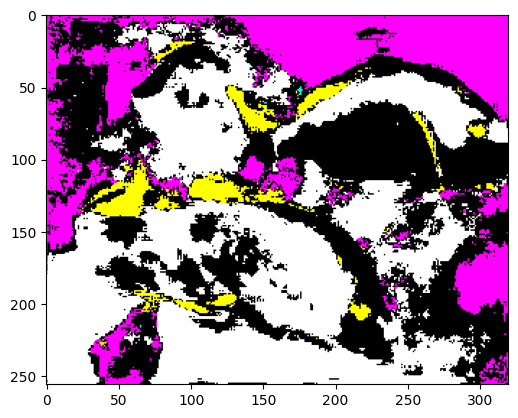

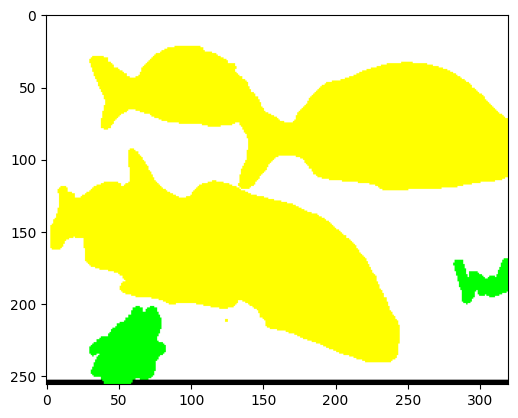

 65%|██████▌   | 72/110 [01:02<00:31,  1.22it/s]

1/1 [==============================] - 0s 35ms/step


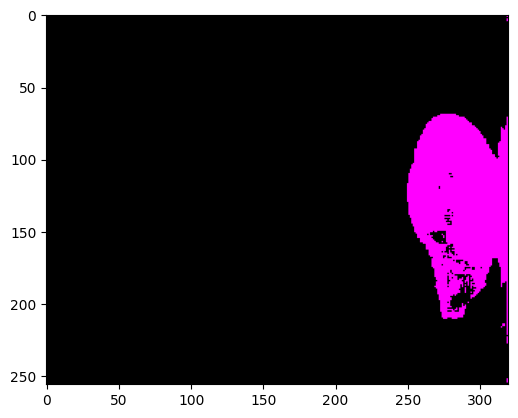

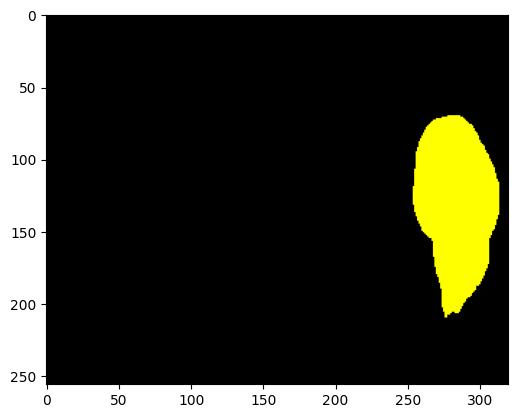

 66%|██████▋   | 73/110 [01:03<00:32,  1.14it/s]

1/1 [==============================] - 0s 39ms/step


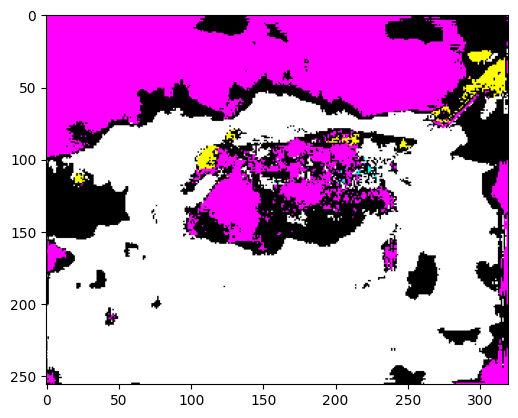

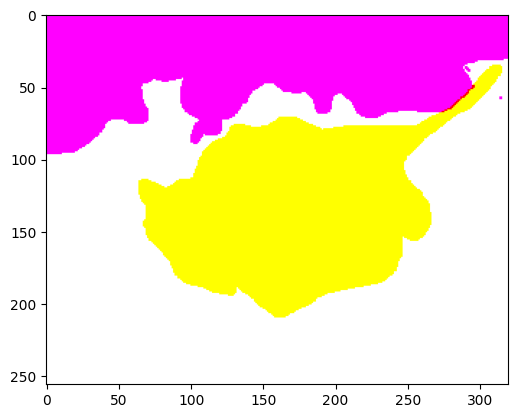

 67%|██████▋   | 74/110 [01:04<00:33,  1.09it/s]

1/1 [==============================] - 0s 38ms/step


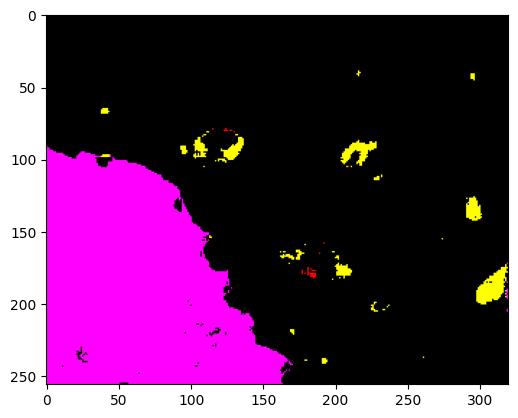

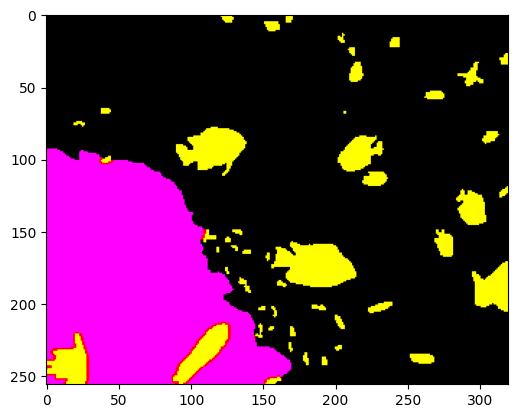

 68%|██████▊   | 75/110 [01:05<00:33,  1.04it/s]

1/1 [==============================] - 0s 38ms/step


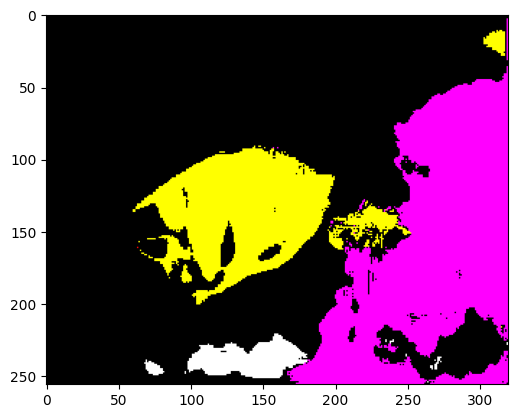

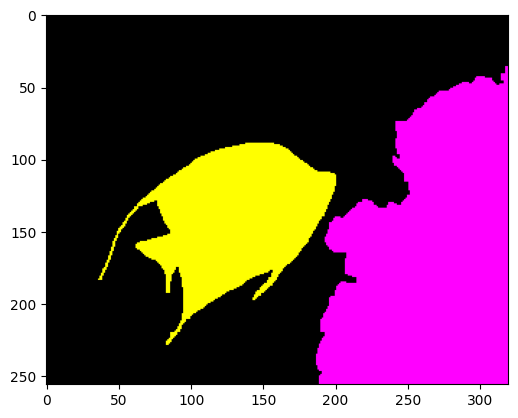

 69%|██████▉   | 76/110 [01:06<00:33,  1.02it/s]

1/1 [==============================] - 0s 31ms/step


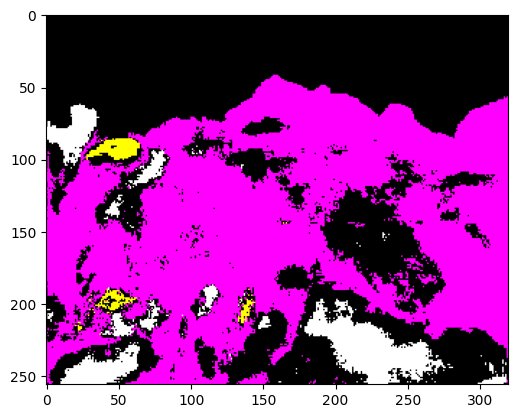

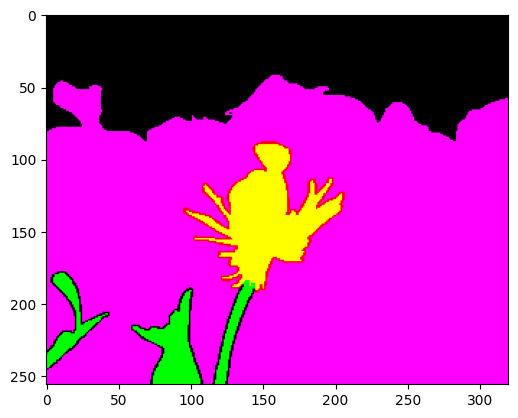

 70%|███████   | 77/110 [01:07<00:33,  1.03s/it]

1/1 [==============================] - 0s 35ms/step


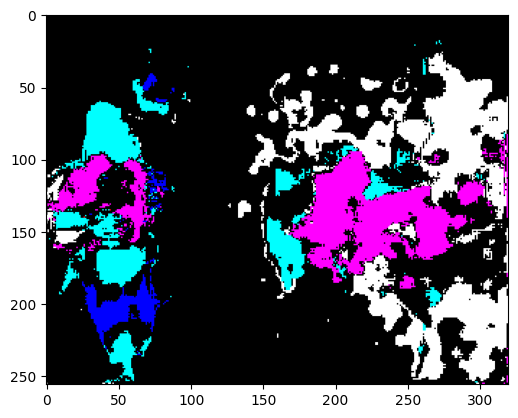

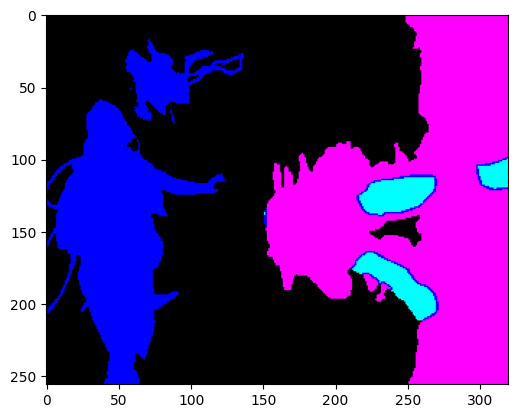

 71%|███████   | 78/110 [01:08<00:33,  1.05s/it]

1/1 [==============================] - 0s 34ms/step


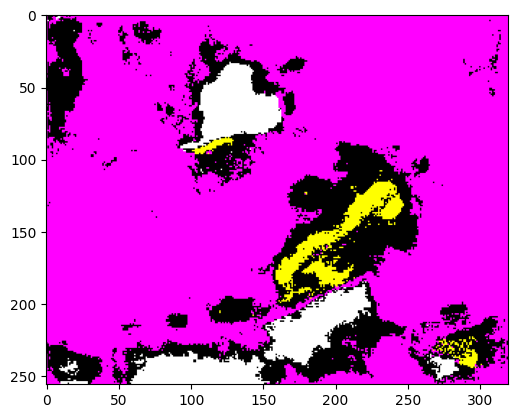

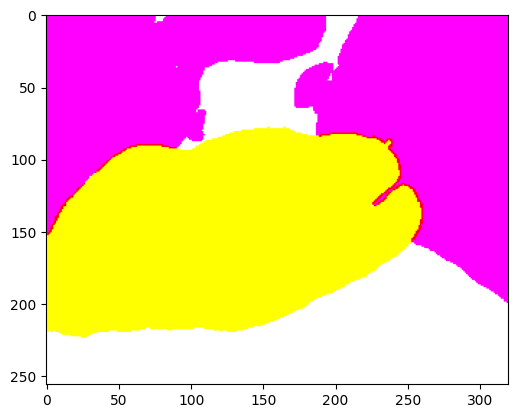

 72%|███████▏  | 79/110 [01:09<00:33,  1.07s/it]

1/1 [==============================] - 0s 45ms/step


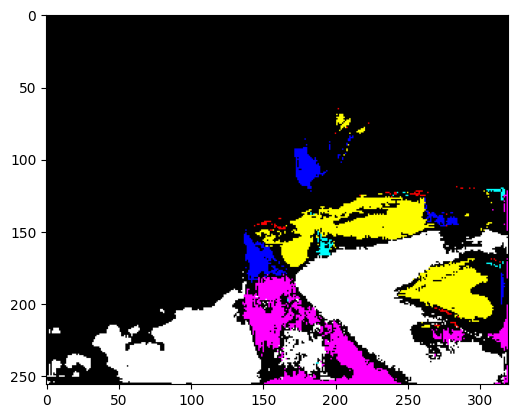

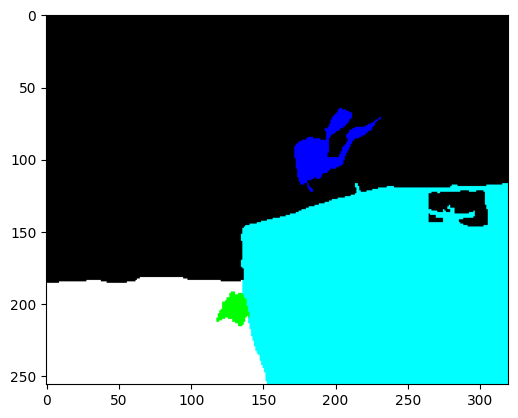

 73%|███████▎  | 80/110 [01:10<00:32,  1.07s/it]

1/1 [==============================] - 0s 75ms/step


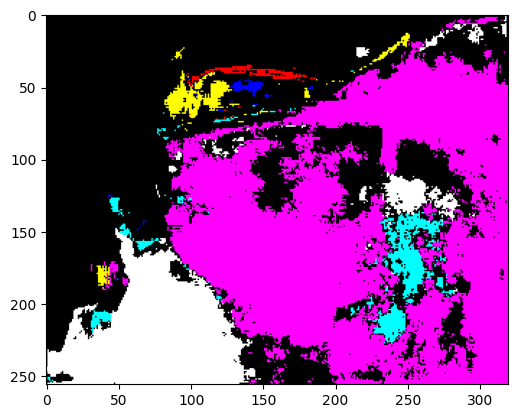

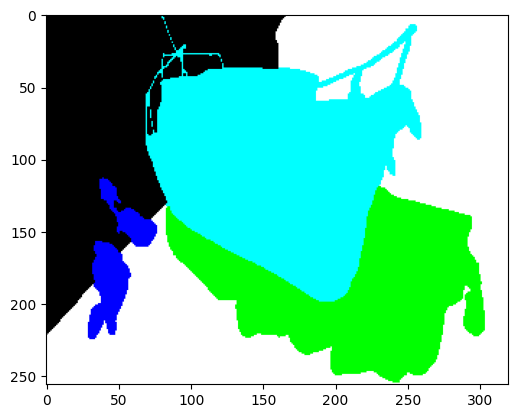

 74%|███████▎  | 81/110 [01:11<00:31,  1.07s/it]

1/1 [==============================] - 0s 41ms/step


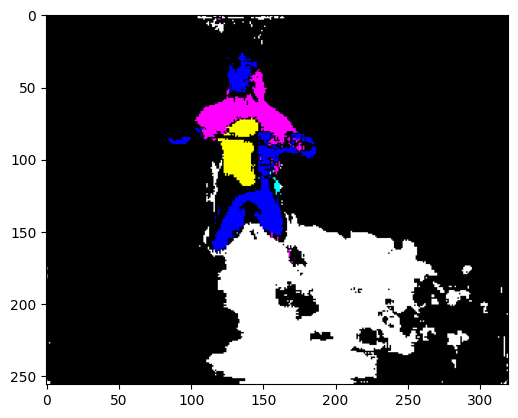

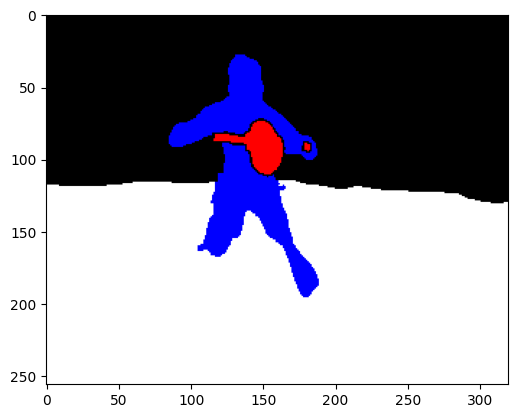

 75%|███████▍  | 82/110 [01:12<00:29,  1.05s/it]

1/1 [==============================] - 0s 43ms/step


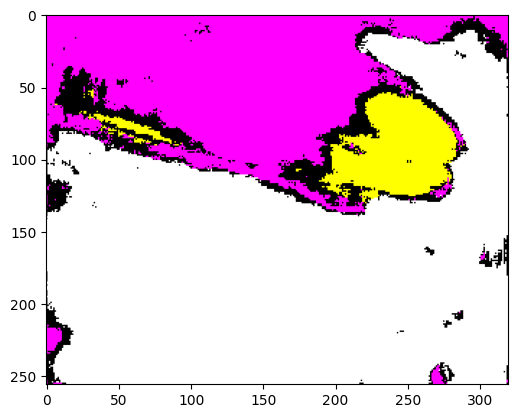

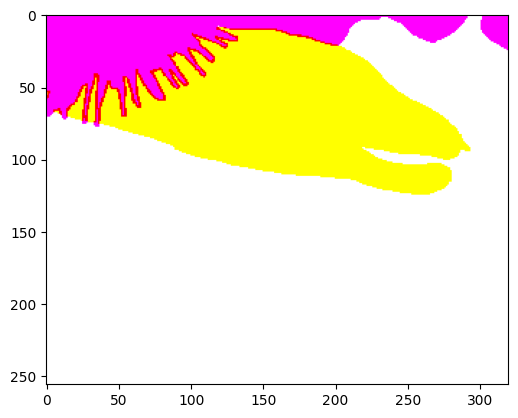

 75%|███████▌  | 83/110 [01:13<00:26,  1.01it/s]

1/1 [==============================] - 0s 34ms/step


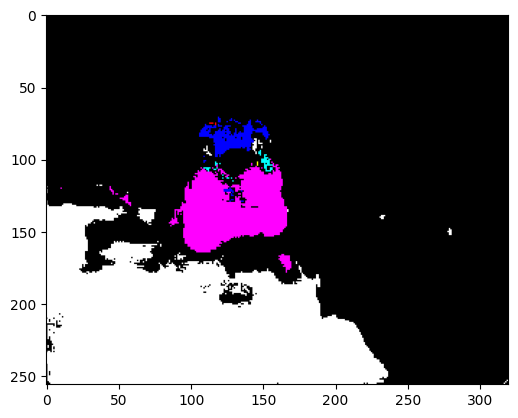

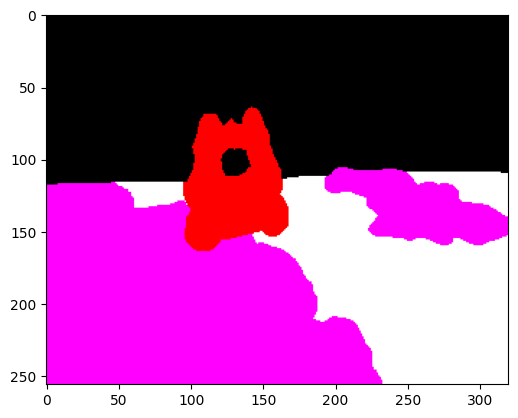

 76%|███████▋  | 84/110 [01:14<00:26,  1.03s/it]

1/1 [==============================] - 0s 34ms/step


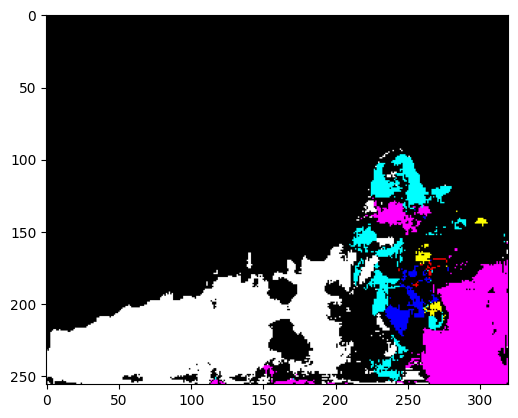

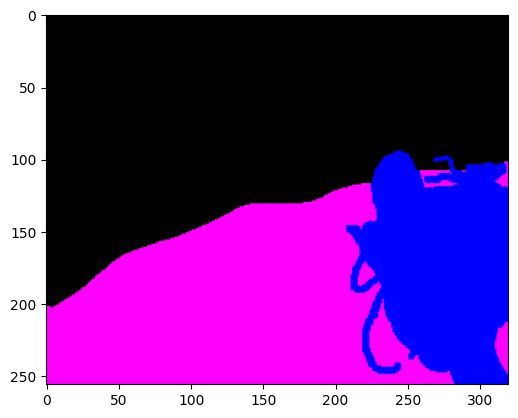

 77%|███████▋  | 85/110 [01:15<00:24,  1.04it/s]

1/1 [==============================] - 0s 35ms/step


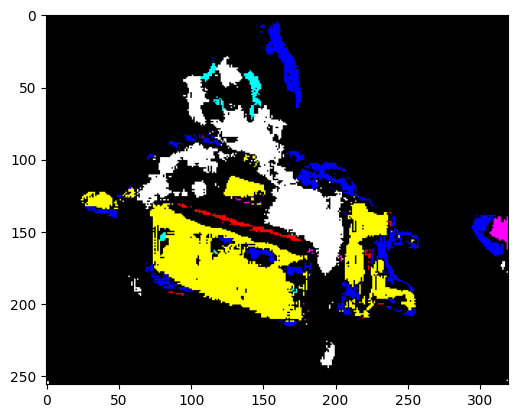

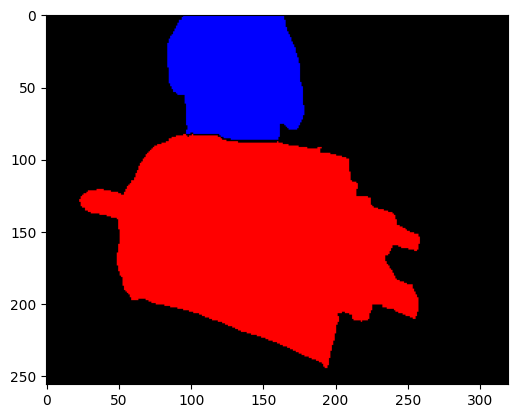

 78%|███████▊  | 86/110 [01:16<00:22,  1.09it/s]

1/1 [==============================] - 0s 31ms/step


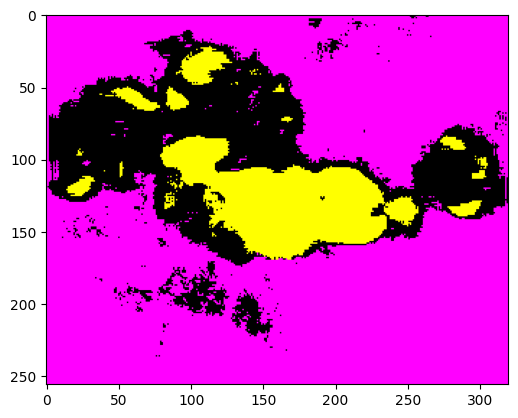

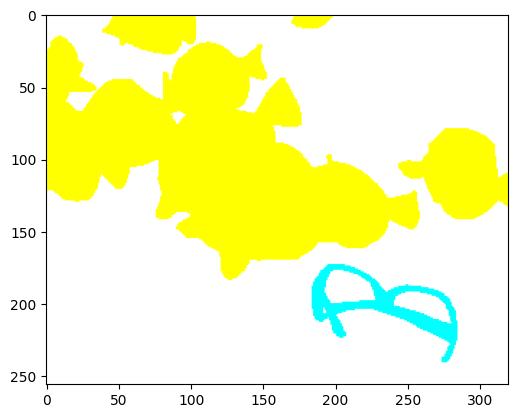

 79%|███████▉  | 87/110 [01:17<00:20,  1.13it/s]

1/1 [==============================] - 0s 38ms/step


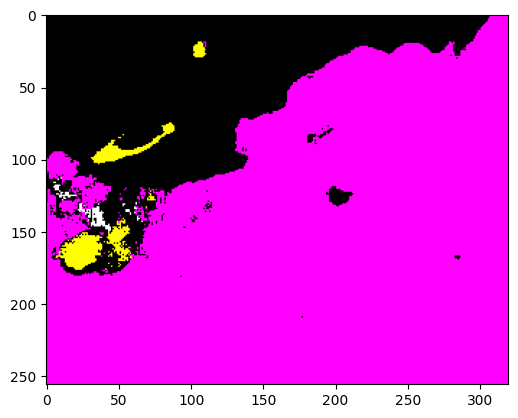

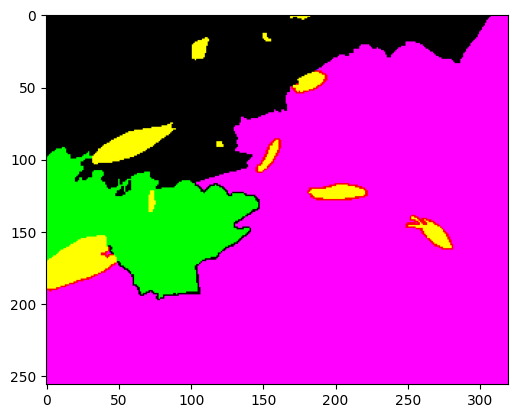

 80%|████████  | 88/110 [01:17<00:19,  1.16it/s]

1/1 [==============================] - 0s 32ms/step


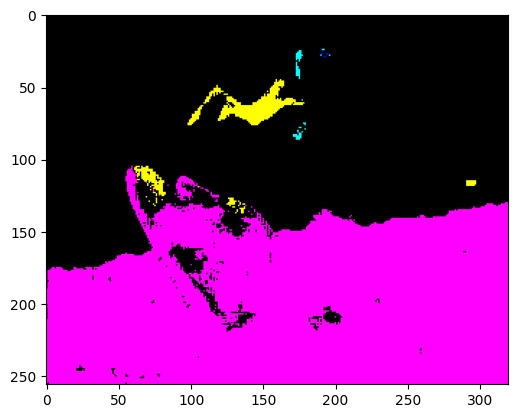

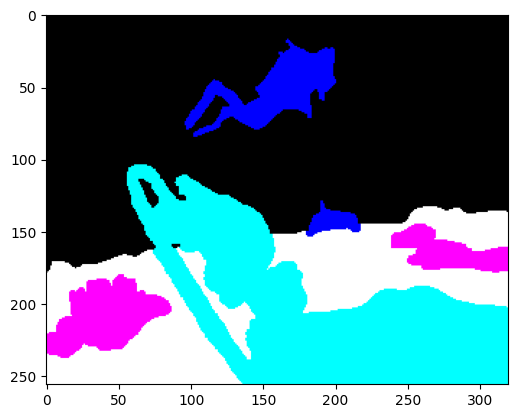

 81%|████████  | 89/110 [01:18<00:17,  1.18it/s]

1/1 [==============================] - 0s 31ms/step


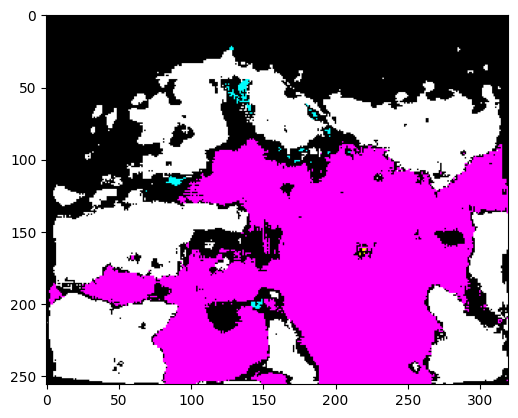

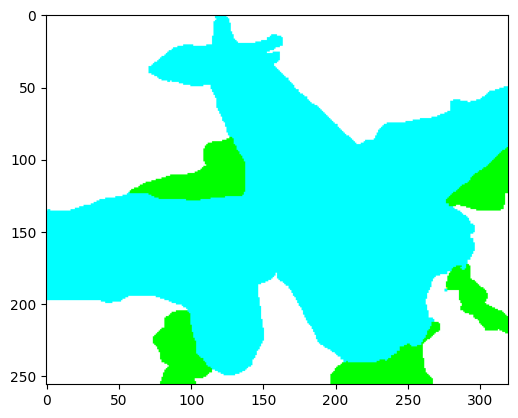

 82%|████████▏ | 90/110 [01:19<00:16,  1.19it/s]

1/1 [==============================] - 0s 30ms/step


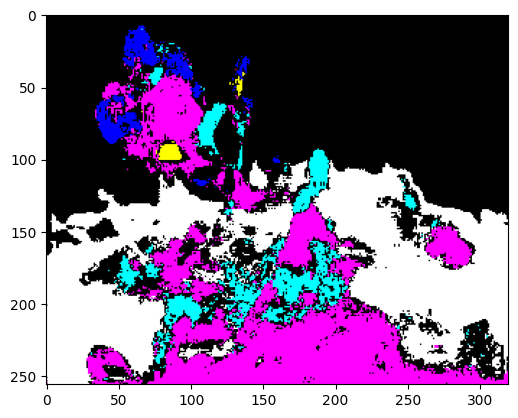

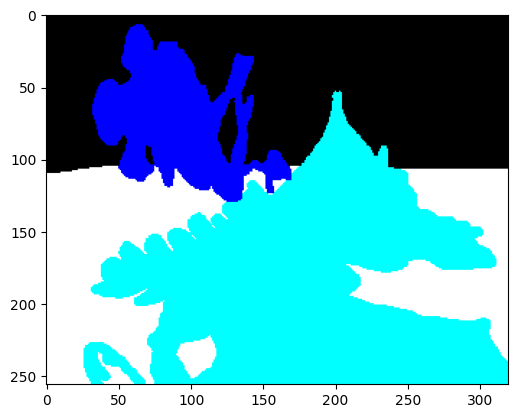

 83%|████████▎ | 91/110 [01:20<00:15,  1.20it/s]

1/1 [==============================] - 0s 34ms/step


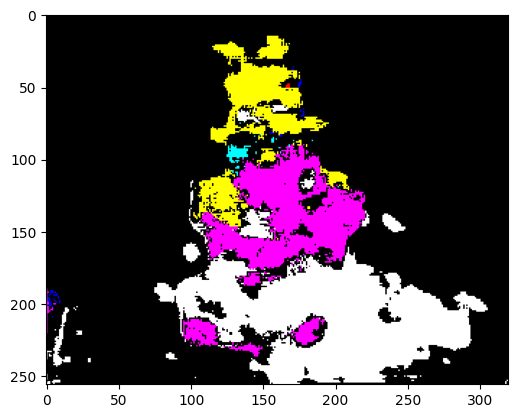

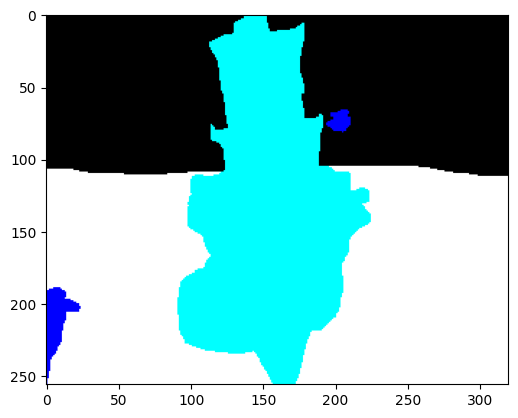

 84%|████████▎ | 92/110 [01:21<00:15,  1.20it/s]

1/1 [==============================] - 0s 29ms/step


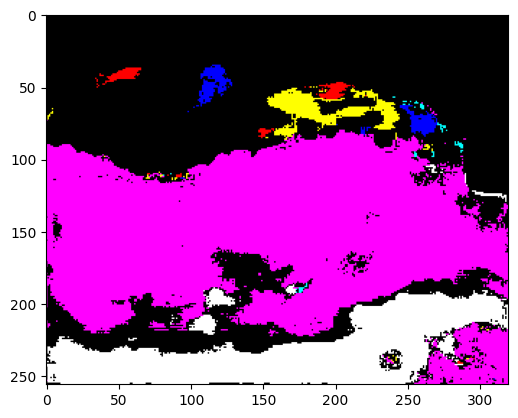

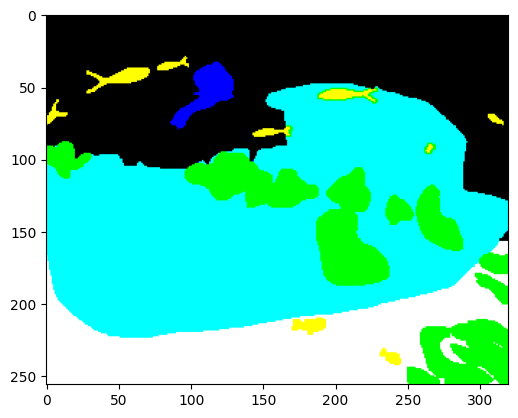

 85%|████████▍ | 93/110 [01:22<00:14,  1.21it/s]

1/1 [==============================] - 0s 31ms/step


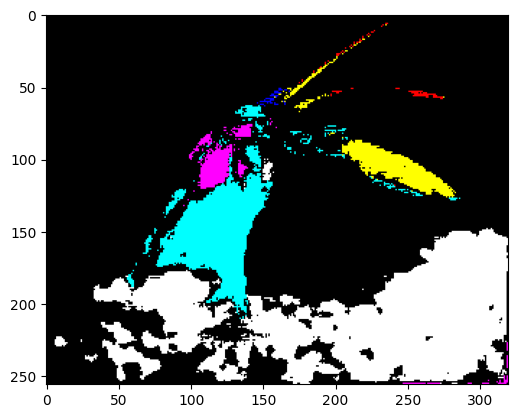

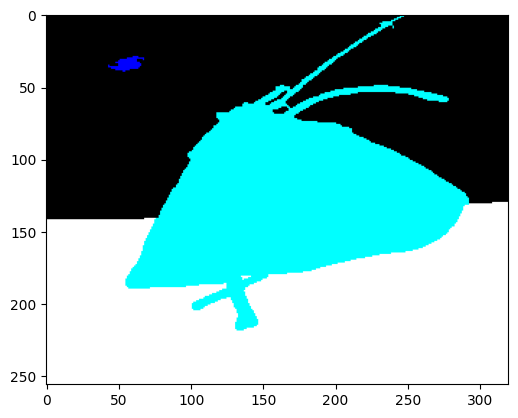

 85%|████████▌ | 94/110 [01:22<00:13,  1.20it/s]

1/1 [==============================] - 0s 41ms/step


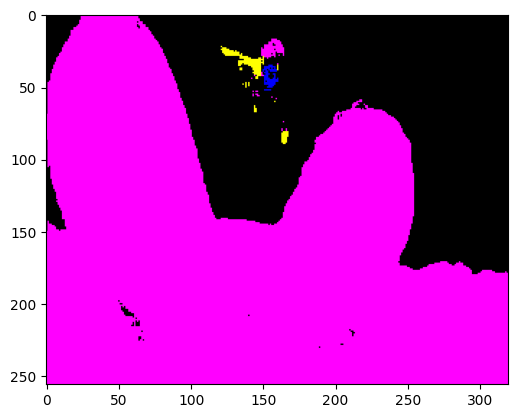

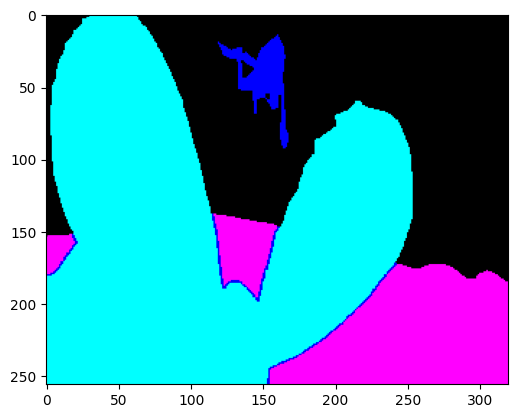

 86%|████████▋ | 95/110 [01:23<00:13,  1.09it/s]

1/1 [==============================] - 0s 39ms/step


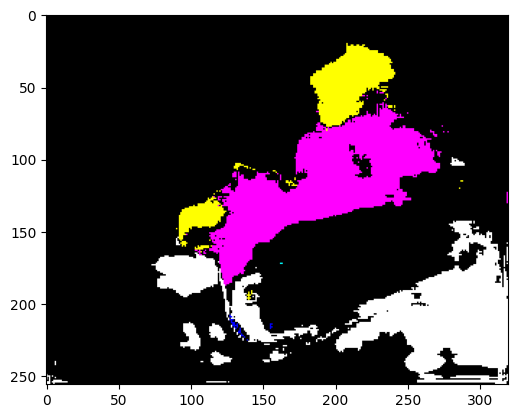

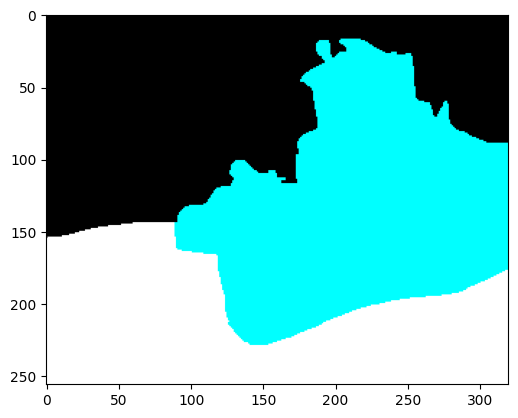

 87%|████████▋ | 96/110 [01:25<00:13,  1.04it/s]

1/1 [==============================] - 0s 32ms/step


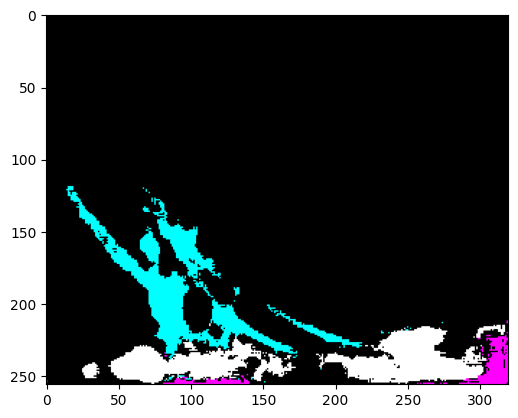

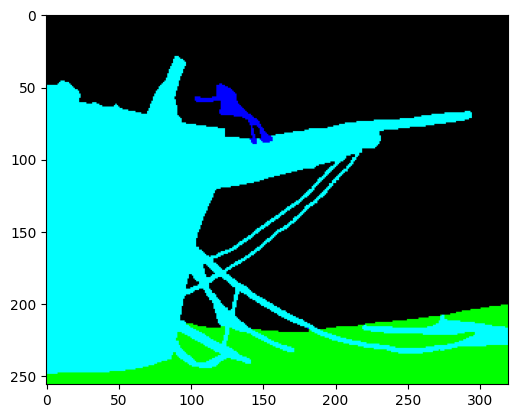

 88%|████████▊ | 97/110 [01:26<00:13,  1.01s/it]

1/1 [==============================] - 0s 48ms/step


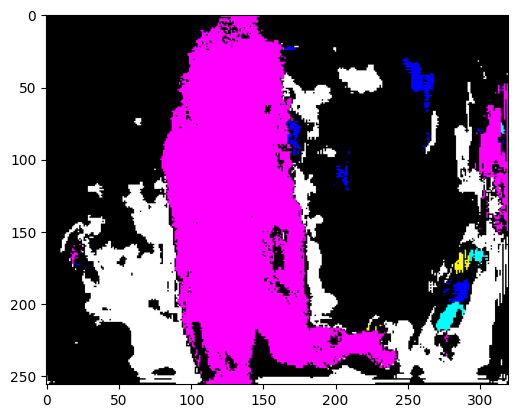

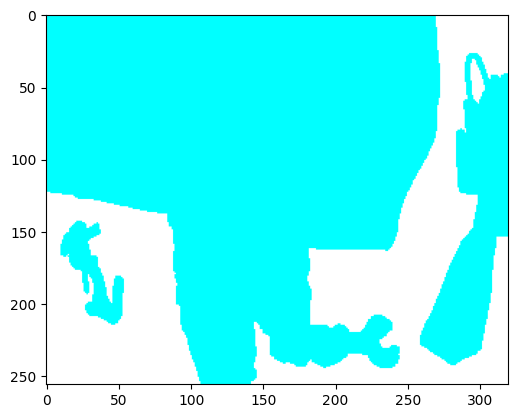

 89%|████████▉ | 98/110 [01:27<00:12,  1.04s/it]

1/1 [==============================] - 0s 61ms/step


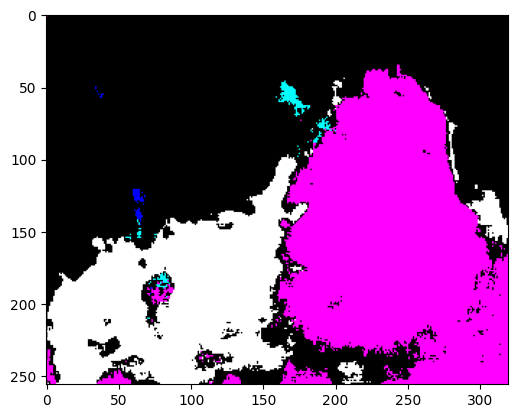

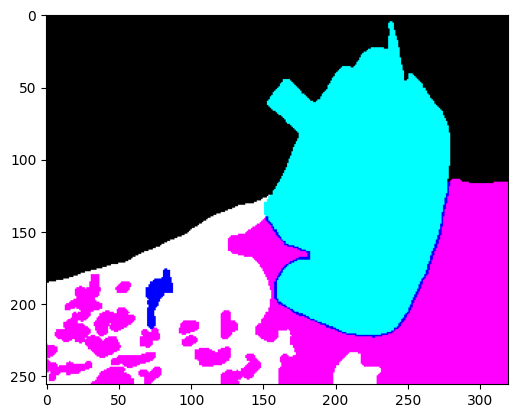

 90%|█████████ | 99/110 [01:28<00:11,  1.04s/it]

1/1 [==============================] - 0s 58ms/step


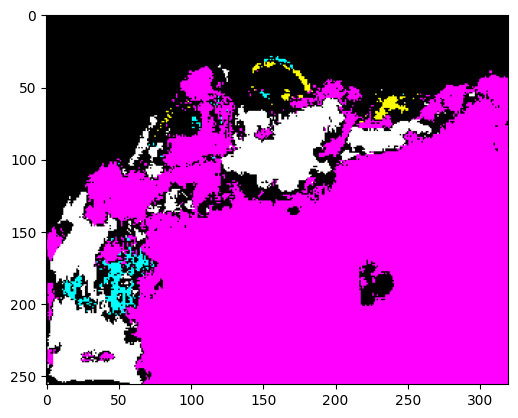

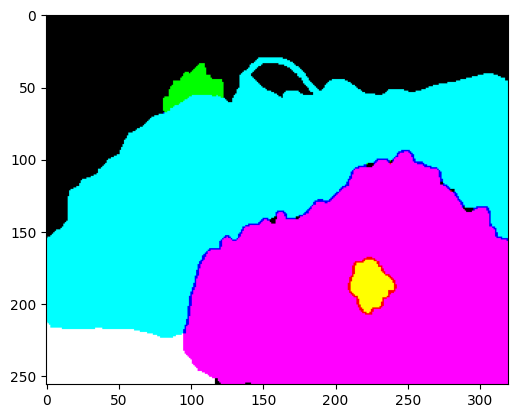

 91%|█████████ | 100/110 [01:29<00:10,  1.05s/it]

1/1 [==============================] - 0s 57ms/step


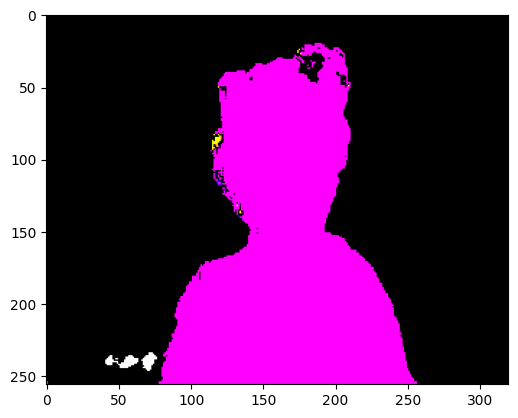

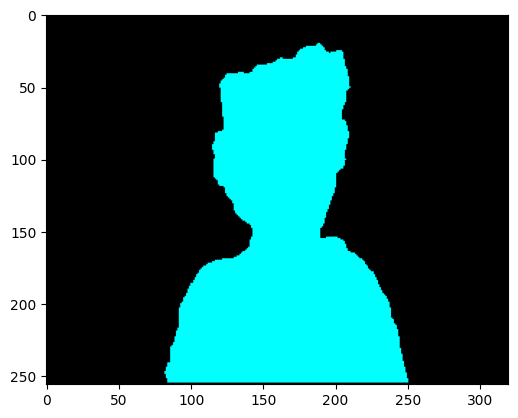

 92%|█████████▏| 101/110 [01:30<00:09,  1.07s/it]

1/1 [==============================] - 0s 47ms/step


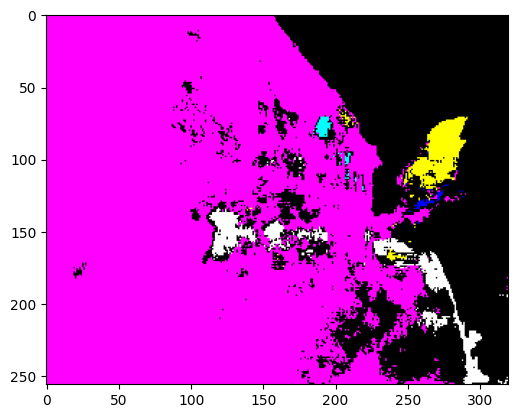

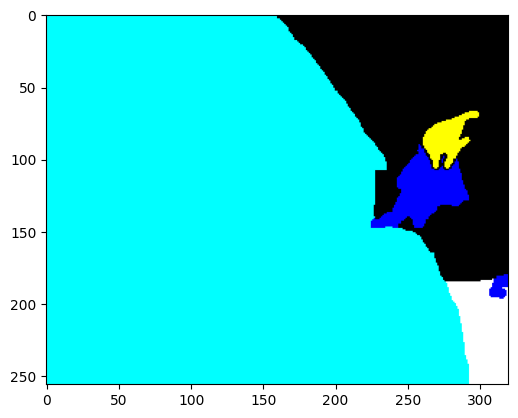

 93%|█████████▎| 102/110 [01:31<00:08,  1.08s/it]

1/1 [==============================] - 0s 68ms/step


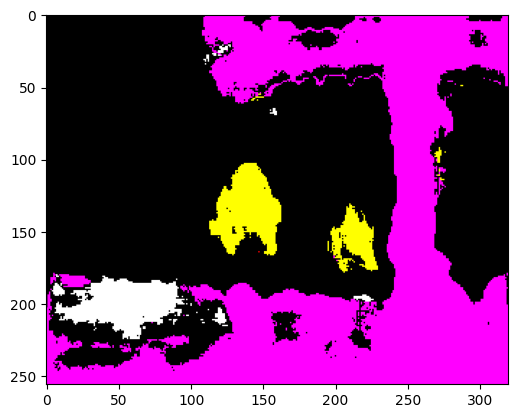

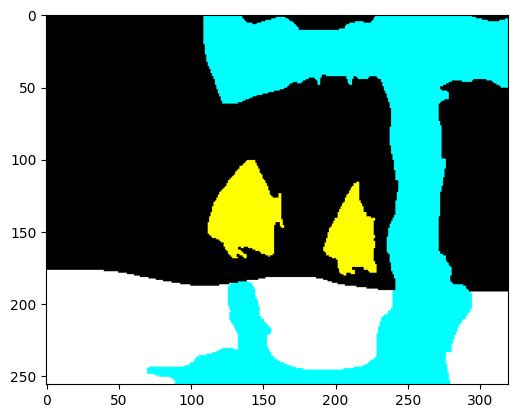

 94%|█████████▎| 103/110 [01:32<00:07,  1.07s/it]

1/1 [==============================] - 0s 36ms/step


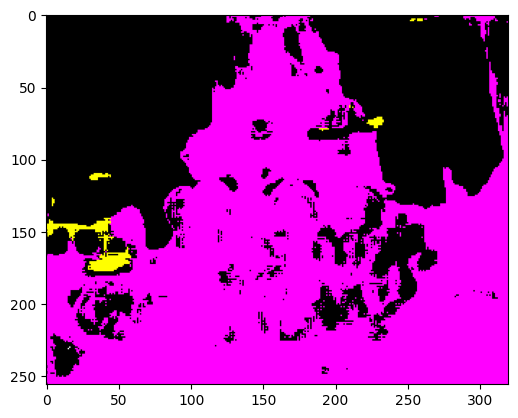

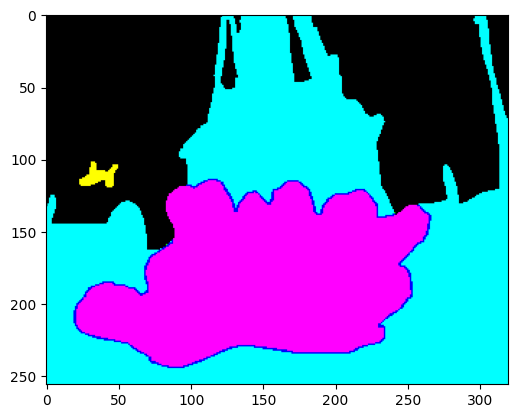

 95%|█████████▍| 104/110 [01:33<00:06,  1.08s/it]

1/1 [==============================] - 0s 35ms/step


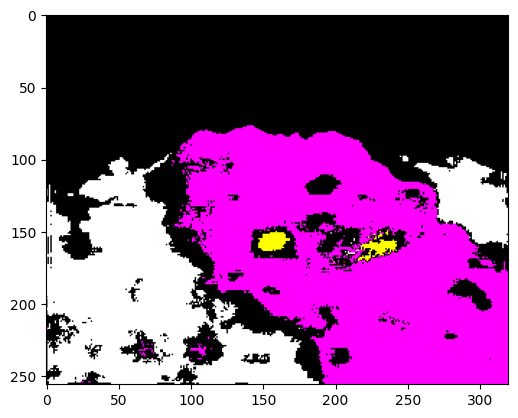

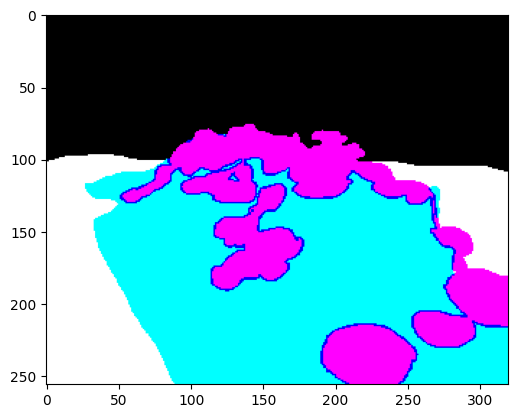

 95%|█████████▌| 105/110 [01:34<00:05,  1.06s/it]

1/1 [==============================] - 0s 60ms/step


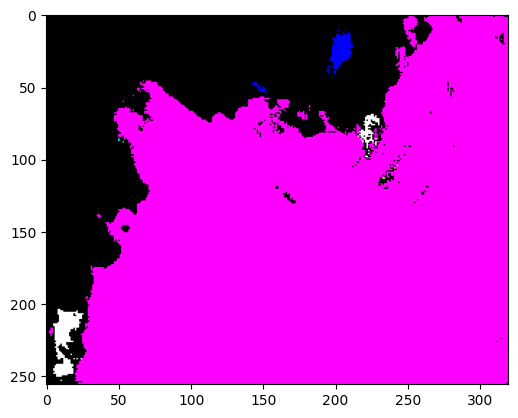

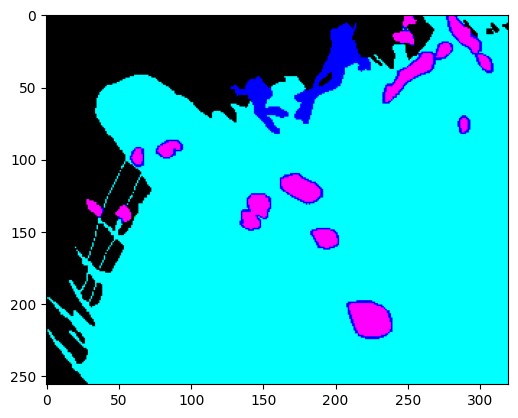

 96%|█████████▋| 106/110 [01:35<00:04,  1.03s/it]

1/1 [==============================] - 0s 28ms/step


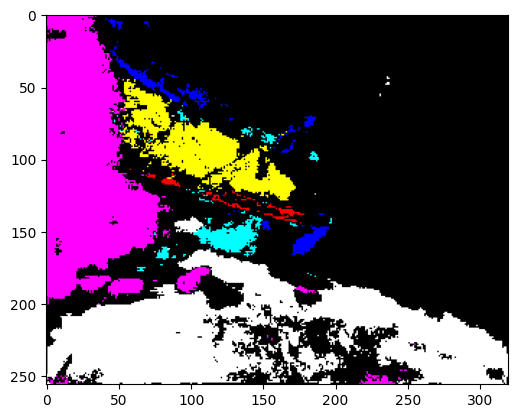

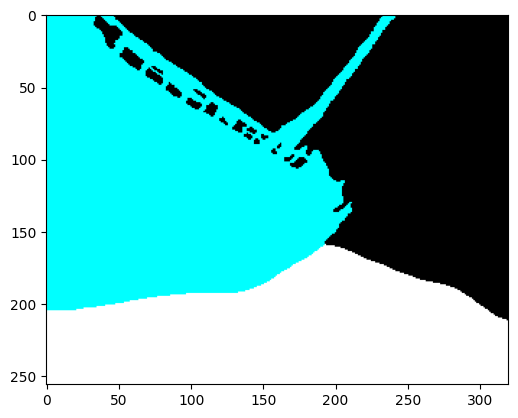

 97%|█████████▋| 107/110 [01:36<00:03,  1.01s/it]

1/1 [==============================] - 0s 30ms/step


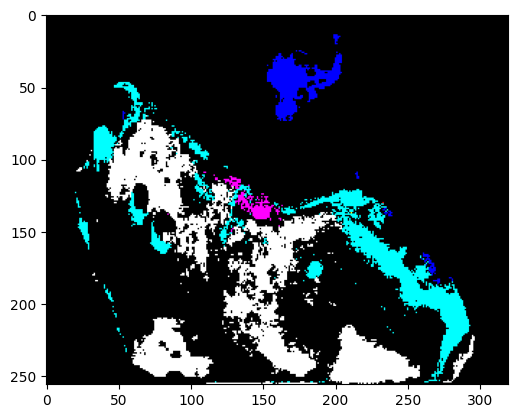

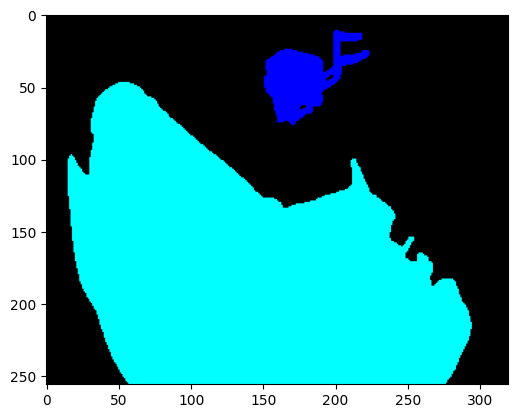

 98%|█████████▊| 108/110 [01:37<00:01,  1.00it/s]

1/1 [==============================] - 0s 30ms/step


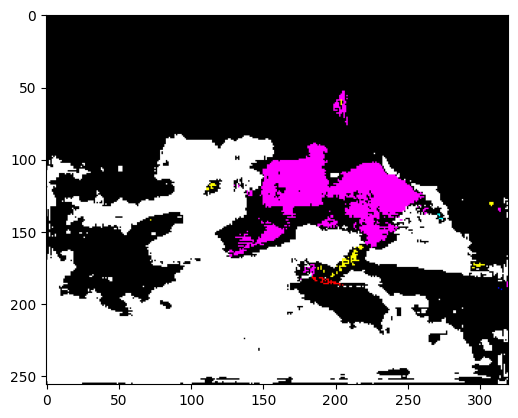

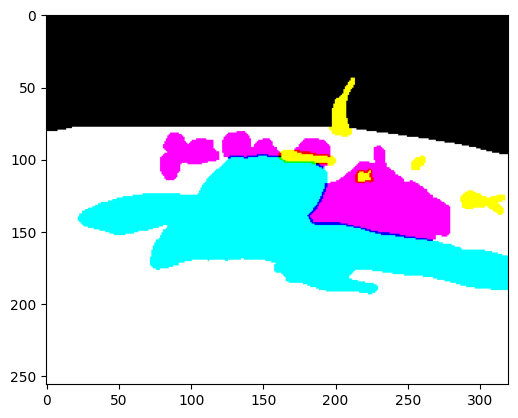

 99%|█████████▉| 109/110 [01:38<00:00,  1.06it/s]

1/1 [==============================] - 0s 45ms/step


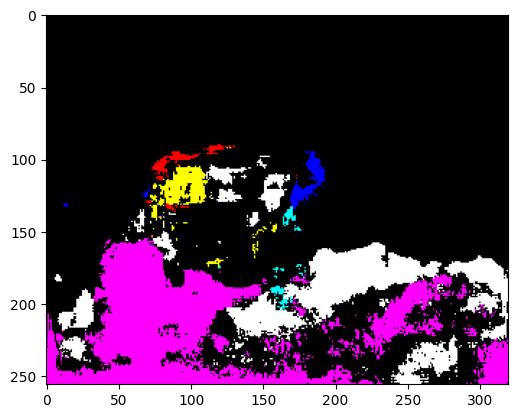

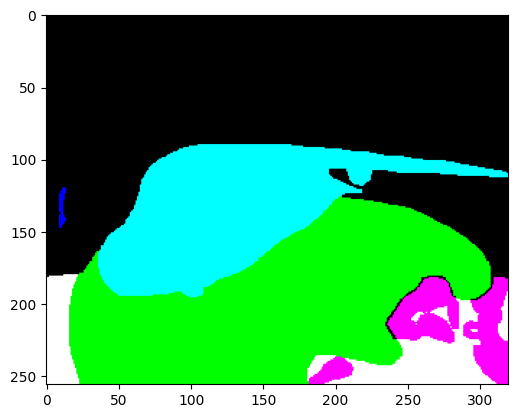

100%|██████████| 110/110 [01:39<00:00,  1.11it/s]


In [42]:
iou_list, iou_by_class, pix_acc = test(model, img_list, labels_list, dataset_folder)

In [39]:
# Validation set
print(np.array(iou_list).mean())
print(np.mean(np.array(iou_by_class), axis=(0),keepdims=True, dtype=np.float16))
print(np.array(pix_acc).mean())

0.6168170792887662
[[0.546  0.569  0.7197 0.6567 0.1785 0.576  0.2732 0.2329]]
0.7443718774318695


In [18]:
# Test set
print(np.array(iou_list).mean())
print(np.mean(np.array(iou_by_class), axis=(0),keepdims=True, dtype=np.float16))
print(np.array(pix_acc).mean())

0.5709524589465235
[[0.694  0.3389 0.721  0.3696 0.1796 0.3354 0.2334 0.3403]]
0.7240518466992811
